# MUTRAFF COMPARE SCENARIOS
Compares two traffic scenarios data analysis based on BASTRA simulator.

Author: Alvaro Paricio. sept.2016

## References
* For Wilcoxon tests:
    * http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html
    * https://gist.github.com/mblondel/1761714
    * http://www.randalolson.com/2012/08/06/statistical-analysis-made-easy-in-python/

## Imports

In [34]:
%matplotlib inline

import os
import fileinput
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
import matplotlib.lines as mlines
import matplotlib as mpl
from IPython.display import display, HTML
# from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from scipy import stats as st

import sklearn as sk
import pandas as pd

# HTML formatting
The toggle button allows code hiding.

In [35]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

### Experiments catalog
Load experiments catalog

Check the notebook **Mutraff Display Experiments** to selected which experiments are available for each scenario.

In [36]:
from MutraffExperiments.ExperimentCatalog import ExperimentCatalog

theExps = ExperimentCatalog('default')
theExps.loadExperimentsFromCSV( 'CATALOGO DE EXPERIMENTOS.csv' )

Created experiment catalog: default
Loading experiment catalog from CATALOGO DE EXPERIMENTOS.csv


### Execution options

In [179]:
# OPTIONS
flag_show_scenarios = True
flag_show_fleets = False
flag_show_heat_maps = False
flag_show_city_map = False
flag_show_heat_maps_speed = True
flag_show_demand_stats = True
flag_show_traveltime_stats = True
flag_show_route_stats = True
flag_show_paired_stats = True
flag_show_paired_histo_secs = True
flag_show_paired_histo_perc = True
flag_show_paired_histo_usage = True
flag_show_paired_histo_cumsum = True
flag_paired_stats_save_csv = False
flag_display_gmaps = False
flag_print_histogram_shape = False
flag_route_calc_num_ON = True
flag_labels_incidents = True
flag_labels_from_catalog = True
flag_dump_histograms = False
flag_dump_histograms2 = False
flag_dump_probability = True

conf_paired_stats_confidence = 0.05
conf_single_stats_confidence = 0.05

MID_FONT_SIZE=10
BIG_FONT_SIZE=18
LEGEND_FONT_SIZE=18

exp={}

BASTRA_PATH="/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra"
label1="GRID16/MuTRAFF OFF/full traffic"
label2="GRID16/MuTRAFF ON/full traffic/1MAP/random5/logit100"

### Function: set_experiments
Scenarios setup

In [38]:
exp_idx1=0
exp_idx2=0
experiment1=""
experiment2=""
label1=""
label2=""
CAT_LABEL1=""
CAT_LABEL2=""
def set_experiments(idx1,idx2):
    global experiment1, experiment2, label1, label2, exp_idx1, exp_idx2, CAT_LABEL1, CAT_LABEL2
    exp_idx1=idx1
    exp_idx2=idx2
    experiment1=theExps.experiments[idx1]['FILE']
    experiment2=theExps.experiments[idx2]['FILE']
    label1=theExps.experiments[idx1]['LABEL']
    label2=theExps.experiments[idx2]['LABEL']
    CAT_LABEL1=theExps.experiments[idx1]['LABEL']
    CAT_LABEL2=theExps.experiments[idx2]['LABEL']

## Functions

In [39]:
# Toggle CODE ON/OFF
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [40]:
# Reporting functions

idx1=0
idx2=0
idx3=0
def print_h0( title ):
    global idx1, idx2, idx3
    display(HTML("<h2>"+ title + "</h2>"))
    display(HTML("<style>div.output_subarea table {font-size: 10px;}</style>"))

    idx1 = 0
    idx2 = 0
    idx3 = 0

def print_h1( title, chapter ):
    global idx1, idx2, idx3
    idx1 +=1
    idx2 = 0
    idx3 = 0
    display(HTML("<h4>"+str(idx1)+". "+ title+". "+ chapter + "</h4>"))

def print_h2( title, chapter ):
    global idx1, idx2, idx3
    idx2 +=1
    idx3 = 0
    display(HTML("<h5>"+str(idx1)+"."+str(idx2)+". "+ title+". "+ chapter + "</h5>"))

def print_h3( title, chapter ):
    global idx1, idx2, idx3
    idx3 +=1
    display(HTML("<h6>"+str(idx1)+"."+str(idx2)+"."+str(idx3)+". "+ title+". "+ chapter + "</h6>"))


In [41]:
#### Function str_vals_percent
# Given two values, print them with their percent difference
def str_val( n ):
    return "{0:.2f}".format(n)
def str_perc( n1, n2 ):
    txt = "{0:.2f}".format((n2-n1)*100/n1) + "%"
    return txt
def str_vals_percent( n1, n2 ):
    return "[" + str_val(n1) + "," + str_val(n2) +"] "+ str_perc( n1, n2 ) 

In [42]:
#### Function dataset_obtain_unique_fleets
# Extract unique values for 'veh_types' column from the datasets.
#
# Support 0,1,2 datasets. Easy to extend to more dataserts. Not needed by now.
def dataset_obtain_unique_fleets( *ds ):
    size = len(ds)
    if( len(ds) == 0):
        return []
    if( len(ds) == 1):
        return ds[0]['veh_type'].unique()
    if( len(ds) == 2):
        vt1 = ds[0]['veh_type'].unique()
        vt2 = ds[1]['veh_type'].unique()
        return list(set().union(vt2, vt2))

In [43]:
#### Function dataset_filter_per_veh_type
# Filter a dataset per type of veh_type
def dataset_filter_per_veh_type(ds, vt):
    return ds.loc[ ds['veh_type']==vt ]

In [178]:
def compare_values(diff,op):
  if( diff==0):
    return "hasn't changed"
  if( op == '>'):
    return "has improved" if diff>0 else "gets worse"
  if( op == '<'):
    return "has improved" if diff<0 else "gets worse"
  return ""

#### Function printPairedStats
# Print paired statistics for two data sets
# Print Statistics for paired values
def printPairedStats( title, label1, ds_raw1, label2, ds_raw2 ):
    if( not flag_show_paired_stats ):
        return

    confidence_str = str(conf_paired_stats_confidence)+"%"
    # Copy DataFrames and change column names
    ds1 = ds_raw1.loc[ ds_raw1['t_arrival_secs'] > 0 ].copy()
    ds2 = ds_raw2.loc[ ds_raw2['t_arrival_secs'] > 0 ].copy()
    # WARNING: CHECK WITH THIS SENTENCE THAT EVERYTHING IS CORRECT:
    # print(ds1.columns)
    # print(ds2.columns)
    if flag_route_calc_num_ON:
        ds1.columns = ['id1','veh_type1','t_depart_secs1','t_arrival_secs1','t_traveltime_secs1',
                   'origin1','destiny1', 'route_calc_num1',
                   'route_detail1','route_path_num1','route_distance1','is_attended1','has_finished1',
                   'maps1','tripfile1']
        ds2.columns = ['id2','veh_type2','t_depart_secs2','t_arrival_secs2','t_traveltime_secs2',
                   'origin2','destiny2', 'route_calc_num2',
                   'route_detail2','route_path_num2','route_distance2','is_attended2','has_finished2',
                   'maps2','tripfile2']
    else:
        ds1.columns = ['id1','veh_type1','t_depart_secs1','t_arrival_secs1','t_traveltime_secs1',
                   'origin1','destiny1',
                   'route_detail1','route_path_num1','route_distance1','is_attended1','has_finished1',
                   'maps1','tripfile1']
        ds2.columns = ['id2','veh_type2','t_depart_secs2','t_arrival_secs2','t_traveltime_secs2',
                   'origin2','destiny2',
                   'route_detail2','route_path_num2','route_distance2','is_attended2','has_finished2',
                   'maps2','tripfile2']
        
    # Inner join for vehicles that completed in both scenarios
    ds3 = pd.merge(left=ds1,right=ds2, left_on='id1', right_on='id2')
    ds3['diff_traveltime_secs']=ds3['t_traveltime_secs1']-ds3['t_traveltime_secs2']
    # percent
    ds3['diff_traveltime_perc']=100.0*ds3['diff_traveltime_secs']/ds3['t_traveltime_secs1']

    # Inner join for vehicles that completed and used TWM in both scenarios
    # ds4 used TWM
    # ds5 didn't use TWM
    ds4 = ds3.loc[ ds3['is_attended2'] == True ].copy()
    ds5 = ds3.loc[ ds3['is_attended2'] == False ].copy()

    travel_times1 = ds3['t_traveltime_secs1']
    travel_times2 = ds3['t_traveltime_secs2']

    # --- VARIANCE COMPARISON STATISTICS
    x_t_test  = st.ttest_ind( travel_times1, travel_times2 )
    if( x_t_test.pvalue < conf_paired_stats_confidence ):
        x_t_test_str = "Variances are different (standard independent 2 sample test) "
    else:
        x_t_test_str = "We cannot assure that variances are equal"
    r_t_test  = st.ttest_ind( ds1['route_path_num1'], ds2['route_path_num2'])
    if( r_t_test.pvalue < conf_paired_stats_confidence ):
        r_t_test_str = "Variances are different (standard independent 2 sample test) "
    else:
        r_t_test_str = "We cannot assure that variances are equal"

    # SHAPIRO normality test
    diff_shapiro1_secs=st.shapiro(ds3['diff_traveltime_secs'])
    diff_shapiro1_perc=st.shapiro(ds3['diff_traveltime_perc'])
    diff_shapiro1_secs_str = ("Distrib is not normal" if diff_shapiro1_secs[1] < conf_paired_stats_confidence else "cannot reject that is normal")
    diff_shapiro1_perc_str = ("Distrib is not normal" if diff_shapiro1_perc[1] < conf_paired_stats_confidence else "cannot reject that is normal")

    # SIGN AND RANK SIGN WILCOXON TESTS
    diff_ranksign_test = st.wilcoxon( travel_times1, travel_times2 )
    diff_ranksign_test_str = ("Medians are sensitive different. TWM has a statistical significative impact" if diff_ranksign_test.pvalue < conf_paired_stats_confidence else "cannot reject that Medians are sensitive different")
    
    theStats = pd.DataFrame([
        [ 'Travel Time', 'T-TEST',  '(t_stat)(p_value)', confidence_str, x_t_test_str, 'stat='+str(x_t_test.statistic), 'p_val='+str(x_t_test.pvalue) ],
        [ 'Route Length', 'T-TEST',  '(t_stat)(p_value)', confidence_str, r_t_test_str, 'stat='+str(r_t_test.statistic), 'p_val='+str(r_t_test.pvalue) ],
        [ 'Travel Time', 'Wilcoxon Paired RankSign',  '', confidence_str, diff_ranksign_test_str, 'stat='+str(diff_ranksign_test.statistic), 'p_val='+str(diff_ranksign_test.pvalue) ],
        [ 'Diff in Travel Time', 'Shapiro',  '', confidence_str, r_t_test_str, 'stat='+str(r_t_test.statistic), 'p_val='+str(r_t_test.pvalue) ],
        [ 'Travel Time Diff secs', 'Shapiro Normality', 'secs', confidence_str, diff_shapiro1_secs_str, '', diff_shapiro1_secs[1] ],
        [ 'Travel Time Diff secs', 'mean',  't.units', confidence_str, compare_values(np.mean(ds3['diff_traveltime_secs']),'>'), np.mean(ds3['diff_traveltime_secs']), ''],
        [ 'Travel Time Diff secs', 'median',  't.units', confidence_str, compare_values(np.median(ds3['diff_traveltime_secs']),'>'),np.median(ds3['diff_traveltime_secs']), '' ],
        [ 'Travel Time Diff secs', 'std.deviation',  't.units', confidence_str, compare_values(np.std(ds3['diff_traveltime_secs']),'>'), np.std(ds3['diff_traveltime_secs']), '' ],
        [ 'Travel Time Diff %', 'Shapiro Normality', '%', '', diff_shapiro1_perc_str, '', diff_shapiro1_perc[1] ],
        [ 'Travel Time Diff %', 'mean',  '%', '', compare_values(np.mean(ds3['diff_traveltime_perc']),'>'), np.mean(ds3['diff_traveltime_perc']), ''],
        [ 'Travel Time Diff %', 'median',  '%', '', compare_values(np.median(ds3['diff_traveltime_perc']),'>'), np.median(ds3['diff_traveltime_perc']), '' ],
        [ 'Travel Time Diff %', 'std.deviation',  '%', '', compare_values(np.std(ds3['diff_traveltime_perc']),'>'), np.std(ds3['diff_traveltime_perc']), '' ],
        ])
    theStats.columns = [ '', 'Stat', 'Units', 'confidence', 'Analysis', 'stat', 'pvalue']
    print_h2(title,"PAIRED STATISTICS")
    display(HTML(theStats.to_html()))
    
    if( flag_show_paired_histo_secs ):
        print_h2(title,"PAIRED - Individual Absolute Traveltime Enhancement histogram")
        cols = 80
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhancement (time units)')
        plt.ylabel('Frecuency')
        plt.rc('axes', labelsize=BIG_FONT_SIZE)
        plt.title("Absolute Individual travel time enhancement (time units)" )

        # y_vals_secs, x_bins, patches = ax.hist(ds3['diff_traveltime_secs'], cols, normed=0, color=['blue'], alpha=0.30, histtype='bar')
        y_vals_secs, x_bins, patches = ax.hist(ds3['diff_traveltime_secs'], cols, normed=0, color=['red'], histtype='bar')

        plt.show()

    if( flag_show_paired_histo_perc ):
        print_h2(title,"PAIRED - Individual Relative Traveltime Enhancement histogram %")
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhancement (%)')
        plt.ylabel('Frecuency')
        plt.rc('axes', labelsize=BIG_FONT_SIZE)
        plt.title("Percentual Relative Individual travel time enhancement" )

        # bins = np.linspace(-100, 100, 200)
        # y_vals, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], bins, normed=0, color=['blue'], alpha=0.30, histtype='bar')
        cols = 80

        # y_vals, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], cols, normed=0, color=['blue'], alpha=0.30, histtype='bar')
        y_vals, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], cols, normed=0, color=['red'], histtype='bar')

        plt.show()

        # Percent Graphic zoom...
        bins = np.linspace(-100, 100, 200)
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhancement (%)')
        plt.ylabel('Frecuency')
        plt.rc('axes', labelsize=BIG_FONT_SIZE)

        # plt.title("(Zoomed -100%,100%) Percentual Individual travel time enhancement (% enhancement relative to original travel time)" )
        plt.title("Percentual Relative Individual travel time enhancement (zoom -100%,100%)" )

        if flag_dump_histograms2:
            bins = np.arange(-100, 100, 2)

        # y_vals, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], bins, normed=0, color=['blue'], alpha=0.30, histtype='bar')
        y_vals, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], bins, normed=0, color=['red'], histtype='bar')

        if( flag_dump_histograms2 ):
            exp_file="OUTPUT/{}.indivRelEnhance.csv".format("alcala_adh_XXXX")
            aux_df = pd.DataFrame(list(zip(x_bins, y_vals)), columns =['BIN', label2]) 
            aux_df.reset_index().to_csv(exp_file, index=False, header=True, sep=';', decimal=',', float_format='%.3f')
            print("DUMPED FILE: "+exp_file+" for (-100,100)")


        plt.show()
        if( flag_show_paired_histo_cumsum ):
            print_h2(title,"PAIRED - Cumulative distribution of Individual Traveltime Enhancement")
            fig, ax = plt.subplots(figsize=(18,8))

            bins = len(y_vals)
            y_cum = np.cumsum(y_vals)
            y_cum_max = y_cum[bins-1]
            y_cum = y_cum/y_cum_max

            x1 = np.ones(bins)
            x_cum = np.cumsum(x1)
            #x_cum = x_cum/bins

            #print( "Enhancement differences (X):", x_cum )
            #print( "Enhancement differences (Y):", y_cum )
            if flag_dump_probability:
                exp_file="OUTPUT/{}.cumProb.csv".format("alcala_adh_XXXX")
                aux_df = pd.DataFrame(list(zip(x_cum, y_cum)), columns =['BIN', "PROB"]) 
                aux_df.reset_index().to_csv(exp_file, index=False, header=True, sep=';', decimal=',', float_format='%.3f')
                print("DUMPED FILE: "+exp_file+" for (-100,100)")

                
            plt.title("Cumulative distribution of Individual travel time enhancement" )
            plt.xlabel('Travel Time Enhancenment')
            plt.ylabel('Probability')
            plt.rc('axes', labelsize=BIG_FONT_SIZE)
            # plot the cumulative function
            # plt.plot(base[:-1], cumulative, c='red')
            plt.plot(x_cum, y_cum, c='red')
            # plot the survival function
            # plt.plot(base[:-1], len(ds3['diff_traveltime_perc'])-cumulative, c='brown')
            plt.show()

    if( flag_show_paired_histo_usage ):
        print_h2(title,"PAIRED - TWM Usage - Individual absolute traveltime enhancement histogram")
        # Graph for Using TWM or not
        cols = 80
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhancement based on TWM usage (time units)')
        plt.ylabel('Frecuency')
        plt.rc('axes', labelsize=BIG_FONT_SIZE)
        plt.title("Absolute Individual travel time enhancenment (time units)" )

        if flag_labels_incidents:
            # ax.hist([ds4['diff_traveltime_secs'],ds5['diff_traveltime_secs']], cols, color=['red','green'], label=['Incident','Normal'], alpha=0.7, histtype='bar')      
            ax.hist([ds4['diff_traveltime_secs'],ds5['diff_traveltime_secs']], cols, color=['red','green'], label=[CAT_LABEL2,CAT_LABEL1], alpha=0.7, histtype='bar')      
        else:
            ax.hist([ds4['diff_traveltime_secs'],ds5['diff_traveltime_secs']], cols, color=['red','green'], label=['Using TWM','Not using TWM'], alpha=0.7, histtype='bar')      
        ax.grid(True)
        ax.legend(loc='upper right', fontsize=LEGEND_FONT_SIZE)
        plt.show()
        
        print_h2(title,"PAIRED - TWM Usage - Individual relative traveltime enhancement histogram")
        fig, ax = plt.subplots(figsize=(18,8))
        plt.xlabel('Travel Time Enhancement (%)')
        plt.ylabel('Frecuency')
        plt.rc('axes', labelsize=BIG_FONT_SIZE)
        plt.title("Percentual Relative Individual travel time enhancement" )

        cols = 80
        if flag_labels_incidents:
            # ax.hist([ds4['diff_traveltime_perc'],ds5['diff_traveltime_perc']], cols, color=['red','green'], label=['Incident','Normal'], alpha=0.7, histtype='bar')
            ax.hist([ds4['diff_traveltime_perc'],ds5['diff_traveltime_perc']], cols, color=['red','green'], label=[CAT_LABEL2,CAT_LABEL1], alpha=0.7, histtype='bar')
        else:
            ax.hist([ds4['diff_traveltime_perc'],ds5['diff_traveltime_perc']], cols, color=['red','green'], label=['Using TWM','Not using TWM'], alpha=0.7, histtype='bar')
        ax.grid(True)
        ax.legend(loc='upper left', fontsize=LEGEND_FONT_SIZE)
        plt.show()

        # Percent Graphic zoom...
        bins = np.linspace(-100, 100, 100)
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhancement (%)')
        plt.ylabel('Frecuency')
        plt.rc('axes', labelsize=BIG_FONT_SIZE)
        # plt.title("(Zoomed -100%,100%) Percentual Individual travel time enhancement based on TWM usage" )
        plt.title("Percentual Relative Individual travel time enhancement (zoom -100%,100%)" )

        if flag_dump_histograms2:
            bins = np.arange(-100, 100, 2)

        if flag_labels_incidents:
            # ax.hist([ds4['diff_traveltime_perc'],ds5['diff_traveltime_perc']], bins, color=['red','green'], label=['Incident','Normal'], alpha=0.7, histtype='bar')
            [y_vals1, y_vals2], x_bins, patches = ax.hist([ds4['diff_traveltime_perc'],ds5['diff_traveltime_perc']], bins, color=['red','green'], label=[CAT_LABEL2,CAT_LABEL1], alpha=0.7, histtype='bar')
        else:
            [y_vals1, y_vals2], x_bins, patches = ax.hist([ds4['diff_traveltime_perc'],ds5['diff_traveltime_perc']], bins, color=['red','green'], label=['Using TWM','Not using TWM'], alpha=0.7, histtype='bar')

        if( flag_dump_histograms2 ):
            exp_file="OUTPUT/{}.indivRelEnhance_NO_YES.csv".format("alcala_adh_XXXX")
            aux_df = pd.DataFrame(list(zip(x_bins, y_vals1, y_vals2)), columns =['BIN', "NO", "YES"]) 
            aux_df.reset_index().to_csv(exp_file, index=False, header=True, sep=';', decimal=',', float_format='%.3f')
            print("DUMPED FILE: "+exp_file+" for (-100,100)")

            
        ax.grid(True)
        ax.legend(loc='upper left', fontsize=LEGEND_FONT_SIZE)
        plt.show()

    if( flag_paired_stats_save_csv ):
        stats_file = '/tmp/mutraff-'+label1+"-"+label2+".csv"
        ds3.to_csv( stats_file )
        print( "Saved file " + stats_file )


In [109]:
#### Function draw_2histograms
# Plots the comparison between two overlapped histograms based on the datasets.
def draw_2histograms( title, label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 ):
    print("CAT_LABEL1:"+CAT_LABEL1)
    confidence_str = str(conf_single_stats_confidence)+"%"

    ds1 = ds_raw1.loc[ ds_raw1['t_arrival_secs'] > 0 ]
    ds2 = ds_raw2.loc[ ds_raw2['t_arrival_secs'] > 0 ]
    ds3 = ds_raw2.loc[ ds_raw2['is_attended'] == True ]

    travel_times1 = ds1['t_traveltime_secs']
    travel_times2 = ds2['t_traveltime_secs']
    travel_times = [ travel_times1, travel_times2 ]

    cols = 80
    fig, ax = plt.subplots(figsize=(18,8))

    plt.xlabel('Travel Time')
    plt.ylabel('Frecuency')
    plt.rc('axes', labelsize=BIG_FONT_SIZE, titlesize=BIG_FONT_SIZE)
    # plt.title("Travel Times Histogram: "+label1+" <--> "+label2 )
    plt.title("Traveltime Histograms Compared" )
    
    # y_vals1, x_bins1, patches1 = ax.hist(travel_times1, histtype='bar', cols, normed=0, facecolor='green', alpha=0.30)
    # y_vals2, x_bins2, patches2 = ax.hist(travel_times2, histtype='bar', cols, normed=0, facecolor='blue', alpha=0.30)
    # [y_vals1, y_vals2], x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green', 'red'], alpha=0.30, histtype='bar')
    if flag_dump_histograms:
        cols = np.arange(0, 8500, 200)
        
    if flag_labels_incidents:
        # [y_vals1, y_vals2], x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green', 'red'], histtype='bar', label=['Incident','Normal'])
        [y_vals1, y_vals2], x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green', 'red'], histtype='bar', label=[CAT_LABEL1,CAT_LABEL2])
    else:
        [y_vals1, y_vals2], x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green', 'red'], histtype='bar', label=['Using TWM','Not using TWM'])

    if( flag_dump_histograms ):
        exp_file="OUTPUT/{}.traveltimes.csv".format(experiment2)
        aux_df = pd.DataFrame(list(zip(x_bins, y_vals1, y_vals2)), columns =['BIN', label1, label2]) 
        aux_df.reset_index().to_csv(exp_file, index=False, header=True, sep=';', decimal=',', float_format='%.3f')
        print("DUMPED FILE: "+exp_file)
        
        #exp_file="OUTPUT/{}.traveltimes.csv".format(experiment2)
        #travel_times2.to_csv(exp_file)
        #print("DUMPED FILE: "+exp_file)
    

    conf_int=0.68
    
    # first histogram ------------------------------------
    x_size1   = len(travel_times1)
    x_mean1   = np.mean(travel_times1)
    x_median1 = np.median(travel_times1)
    x_std1    = np.std(travel_times1)
    x_var1    = np.var(travel_times1)
    x_conf_int1  = st.norm.interval(conf_int, loc=x_mean1, scale=x_std1)
    x_m_conf_int1= st.norm.interval(conf_int, loc=x_mean1, scale=x_std1/np.sqrt(x_size1))
    x_shapiro1=st.shapiro(travel_times1)
    x_shapiro_str1 = confidence_str + ("is not normal" if x_shapiro1[1] < conf_single_stats_confidence else "cannot reject that is normal")
    y_mean1   = np.mean(y_vals1)
    y_median1 = np.median(y_vals1)
    y_std1    = np.std(y_vals1)
    r_mean1   = np.mean(ds1['route_path_num'])
    r_median1 = np.median(ds1['route_path_num'])
    r_std1    = np.std(ds1['route_path_num'])
    r_var1    = np.var(ds1['route_path_num'])
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_m_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1/np.sqrt(x_size1))
    # l_mean1   = np.mean(ds1['route_length'])
    # l_median1 = np.median(ds1['route_length'])
    l_mean1   = 1
    l_median1 = 1

    # add a 'best fit' line
    y1_vals1 = np.append( y_vals1, y_vals1[cols-1] )

    x2_mean1   = [ x_mean1   for i in y1_vals1 ]
    x3_median1 = [ x_median1 for i in y1_vals1 ]
    y2_mean1   = [ y_mean1   for i in x_bins ]
    y3_median1 = [ y_median1 for i in x_bins ]

    # second histogram ------------------------------------
    x_size2   = len(travel_times2)
    x_mean2   = np.mean(travel_times2)
    x_median2 = np.median(travel_times2)
    x_std2    = np.std(travel_times2)
    x_var2    = np.var(travel_times2)
    x_conf_int2  = st.norm.interval(conf_int, loc=x_mean2, scale=x_std2)
    x_m_conf_int2= st.norm.interval(conf_int, loc=x_mean2, scale=x_std2/np.sqrt(x_size2))
    x_shapiro2=st.shapiro(travel_times2)
    x_shapiro_str2 = confidence_str + ("is not normal" if x_shapiro2[1] < conf_single_stats_confidence else "cannot reject that is normal")
    y_mean2   = np.mean(y_vals2)
    y_median2 = np.median(y_vals2)
    y_std2    = np.std(y_vals2)
    r_mean2   = np.mean(ds2['route_path_num'])
    r_median2 = np.median(ds2['route_path_num'])
    r_std2    = np.std(ds2['route_path_num'])
    r_var2    = np.var(ds2['route_path_num'])
    r_conf_int2  = st.norm.interval(conf_int, loc=r_mean2, scale=r_std2)
    r_m_conf_int2= st.norm.interval(conf_int, loc=r_mean2, scale=r_std2/np.sqrt(x_size2))
    r_t_test  = st.ttest_ind( ds1['route_path_num'], ds2['route_path_num'])
    # l_mean2   = np.mean(ds2['route_length'])
    # l_median2 = np.median(ds2['route_length'])
    l_mean2   = 1
    l_median2 = 1
     
    # add a 'best fit' line
    y1_vals2 = np.append( y_vals2, y_vals2[cols-1] )

    x2_mean2   = [ x_mean2   for i in y1_vals2 ]
    x3_median2 = [ x_median2 for i in y1_vals2 ]
    y2_mean2   = [ y_mean2   for i in x_bins ]
    y3_median2 = [ y_median2 for i in x_bins ]

    if( flag_show_demand_stats ):
      theStats = pd.DataFrame([
        [ 'Trips Planned', 'num',  'trips', str_perc(ds_raw1['id'].count(),ds_raw2['id'].count()), ds_raw1['id'].count(), ds_raw2['id'].count()],
        [ 'Trips Routed',  'num',  'trips', str_perc(travel_times1.count(),travel_times2.count()), travel_times1.count(), travel_times2.count()],
        [ 'Trips using TWM',  'num',  'trips', str_perc(travel_times1.count(),len(ds3)), travel_times1.count(), len(ds3)],
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      print_h2(title, "NON-PAIRED STATS - ROUTED DEMAND")
      display(HTML(theStats.to_html()))

    if( flag_show_traveltime_stats ):
      theStats = pd.DataFrame([
        [ 'Travel Time', 'mean',  't.units', str_perc(x_mean1,x_mean2), x_mean1, x_mean2 ],
        [ 'Travel Time', 'median',  't.units', str_perc(x_median1,x_median2), x_median1, x_median2 ],
        # [ 'Travel Time', 'variance',  't.units', str_perc(x_var1,x_var2), x_var1, x_var2 ],
        [ 'Travel Time', 'std.deviation',  't.units', str_perc(x_std1,x_std2), x_std1,x_std2 ],
        [ 'Travel Time', 'Value Confidence Interval',  't.units', '', str(x_conf_int1), str(x_conf_int2) ],
        [ 'Travel Time', 'Mean Confidence Interval',  't.units', '', str(x_m_conf_int1), str(x_m_conf_int2) ],
        [ 'Travel Time', 'Shapiro', '', '', x_shapiro_str1, x_shapiro_str2 ]
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]
      print_h2(title, "NON-PAIRED STATS - TRAVELTIME")
      display(HTML(theStats.to_html()))

    if( flag_show_route_stats ):
      theStats = pd.DataFrame([
        [ 'Route Length', 'mean',  'mts', str_perc(r_mean1,r_mean2), r_mean1, r_mean2 ],
        [ 'Route Length', 'median',  'mts', str_perc(r_median1,r_median2), r_median1, r_median2 ],
        # [ 'Route Length', 'variance',  'mts', str_perc(r_var1,r_var2), r_var1, r_var2 ],
        [ 'Route Length', 'std.deviation',  'mts', str_perc(r_std1,r_std2), r_std1, r_std2 ],
        [ 'Route Length', 'Value Confidence Interval',  'mts', '', str(r_conf_int1), str(r_conf_int2) ],
        [ 'Route Length', 'Mean Confidence Interval',  'mts', '', str(r_m_conf_int1), str(r_m_conf_int2) ],
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      print_h2(title, "NON-PAIRED STATS - ROUTE LENGTH")
      display(HTML(theStats.to_html()))

    print_h2(title, "NON-PAIRED STATS - TRAVELTIMES COMPARED HISTOGRAM")
    if ( flag_print_histogram_shape ):
        line_estimation1 = ax.plot(x_bins, y1_vals1, 'r-', label='Estimation', linewidth=2, color='darkgreen')
        line_estimation2 = ax.plot(x_bins, y1_vals2, 'r-', label='Estimation', linewidth=2, color='darkred')

    max_y = np.linspace(0, max( max(y_vals1), max(y_vals2)), num=len(x_bins))
    line_mean1 = ax.plot(x2_mean1, max_y, label='Mean', linestyle='--', linewidth=2, color='darkgreen')
    line_median1 = ax.plot(x3_median1, max_y, label='Median', linestyle='-', linewidth=2, color='darkgreen')

    line_mean2 = ax.plot(x2_mean2, y1_vals2, label='Mean', linestyle='--', linewidth=2, color='darkred')
    line_median2 = ax.plot(x3_median2, max_y, label='Median', linestyle='-', linewidth=2, color='darkred')

    mean_line1   = mlines.Line2D([], [], linestyle='--',color='darkgreen', markersize=1, label='Mean: '+CAT_LABEL1)
    median_line1 = mlines.Line2D([], [], linestyle='-', color='darkgreen', markersize=1, label='Median: '+CAT_LABEL1)
    mean_line2   = mlines.Line2D([], [], linestyle='--',color='darkred',  markersize=1, label='Mean: '+CAT_LABEL2)
    median_line2 = mlines.Line2D([], [], linestyle='-', color='darkred',  markersize=1, label='Median: '+CAT_LABEL2)
    if flag_labels_incidents:
        # red_patch = mpatches.Patch(color='red', label='Incident')
        # green_patch = mpatches.Patch(color='green', label='No Incident')
        red_patch = mpatches.Patch(color='red', label=CAT_LABEL2)
        green_patch = mpatches.Patch(color='green', label=CAT_LABEL1)
    else:
        red_patch = mpatches.Patch(color='red', label='Using TWM')
        green_patch = mpatches.Patch(color='green', label='Not using TWM')
    ax.legend(handles=[red_patch, green_patch, median_line1, mean_line1, median_line2, mean_line2], loc='upper right', fancybox=True, framealpha=0.5)
    plt.rc('legend', fontsize=LEGEND_FONT_SIZE)
    # plt.axis([travel_times.min(), travel_times.max()+1, 0, 0.03])
    ax.grid(True)

    # If plotting OUTSIDE the notebook, set interactive mode ON/OFF
    # plt.ioff()
    # plt.ion()

    plt.show()

In [57]:
#### Function draw_1histograms
# Plots the comparison between two overlapped histograms based on the datasets.
def draw_1histograms( title, label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 ):
    confidence_str = str(conf_single_stats_confidence)+"%"

    ds1 = ds_raw1.loc[ ds_raw1['t_arrival_secs'] > 0 ]
    ds2 = ds_raw2.loc[ ds_raw2['t_arrival_secs'] > 0 ]
    ds3 = ds_raw2.loc[ ds_raw2['is_attended'] == True ]

    travel_times1 = ds1['t_traveltime_secs']
    travel_times2 = ds2['t_traveltime_secs']
    travel_times = [ travel_times1 ]

    cols = 80
    fig, ax = plt.subplots(figsize=(18,8))

    plt.xlabel('Travel Time')
    plt.ylabel('Frecuency')
    plt.rc('axes', labelsize=BIG_FONT_SIZE, titlesize=BIG_FONT_SIZE)
    # plt.title("Travel Times Histogram: "+label1+" <--> "+label2 )
    plt.title("Traveltime Histograms" )
    
    # y_vals1, x_bins1, patches1 = ax.hist(travel_times1, histtype='bar', cols, normed=0, facecolor='green', alpha=0.30)
    # y_vals2, x_bins2, patches2 = ax.hist(travel_times2, histtype='bar', cols, normed=0, facecolor='blue', alpha=0.30)
    # [y_vals1, y_vals2], x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green', 'red'], alpha=0.30, histtype='bar')
    if flag_labels_incidents:
        # y_vals1, x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green'], histtype='bar', label=['Normal'])
        y_vals1, x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green'], histtype='bar', label=[CAT_LABEL1])
    else:
        y_vals1, x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green'], histtype='bar', label=['Not using TWM'])
    
    conf_int=0.68
    
    # first histogram ------------------------------------
    x_size1   = len(travel_times1)
    x_mean1   = np.mean(travel_times1)
    x_median1 = np.median(travel_times1)
    x_std1    = np.std(travel_times1)
    x_var1    = np.var(travel_times1)
    x_conf_int1  = st.norm.interval(conf_int, loc=x_mean1, scale=x_std1)
    x_m_conf_int1= st.norm.interval(conf_int, loc=x_mean1, scale=x_std1/np.sqrt(x_size1))
    x_shapiro1=st.shapiro(travel_times1)
    x_shapiro_str1 = confidence_str + ("is not normal" if x_shapiro1[1] < conf_single_stats_confidence else "cannot reject that is normal")
    y_mean1   = np.mean(y_vals1)
    y_median1 = np.median(y_vals1)
    y_std1    = np.std(y_vals1)
    r_mean1   = np.mean(ds1['route_path_num'])
    r_median1 = np.median(ds1['route_path_num'])
    r_std1    = np.std(ds1['route_path_num'])
    r_var1    = np.var(ds1['route_path_num'])
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_m_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1/np.sqrt(x_size1))
    # l_mean1   = np.mean(ds1['route_length'])
    # l_median1 = np.median(ds1['route_length'])
    l_mean1   = 1
    l_median1 = 1

    # add a 'best fit' line
    y1_vals1 = np.append( y_vals1, y_vals1[cols-1] )

    x2_mean1   = [ x_mean1   for i in y1_vals1 ]
    x3_median1 = [ x_median1 for i in y1_vals1 ]
    y2_mean1   = [ y_mean1   for i in x_bins ]
    y3_median1 = [ y_median1 for i in x_bins ]

    max_y = np.linspace(0, max(y_vals1), num=len(x_bins))
    line_mean1 = ax.plot(x2_mean1, max_y, label='Mean', linestyle='--', linewidth=2, color='darkgreen')
    line_median1 = ax.plot(x3_median1, max_y, label='Median', linestyle='-', linewidth=2, color='darkgreen')

    mean_line1   = mlines.Line2D([], [], linestyle='--',color='darkgreen', markersize=1, label='Mean: '+CAT_LABEL1)
    median_line1 = mlines.Line2D([], [], linestyle='-', color='darkgreen', markersize=1, label='Median: '+CAT_LABEL1)

    if flag_labels_incidents:
        # red_patch = mpatches.Patch(color='red', label='Incident')
        # green_patch = mpatches.Patch(color='green', label='No Incident')
        red_patch = mpatches.Patch(color='red', label=CAT_LABEL2)
        green_patch = mpatches.Patch(color='green', label=CAT_LABEL1)
    else:
        red_patch = mpatches.Patch(color='red', label='Using TWM')
        green_patch = mpatches.Patch(color='green', label='Not using TWM')

    ax.legend(handles=[green_patch, median_line1, mean_line1], loc='upper right', fancybox=True, framealpha=0.5)
    plt.rc('legend', fontsize=LEGEND_FONT_SIZE)
    # plt.axis([travel_times.min(), travel_times.max()+1, 0, 0.03])
    ax.grid(True)

    # If plotting OUTSIDE the notebook, set interactive mode ON/OFF
    # plt.ioff()
    # plt.ion()

    plt.show()

In [58]:
#### Function map_coord
# Maps edge coordinates into a grid representation for heatmaps.
# Receives as input parameters:
#    * (x,y) values to be mapped
#    * (max, min)(x,y) value ranges for x,y
#    * grid dimensions
# Test code to create distribution in array of heatmap
def map_coord(x,y,min_x,max_x,min_y,max_y,dim_x,dim_y):
    c_x = int(x/(max_x-min_x)*dim_x)
    c_y = int(y/(max_y-min_y)*dim_y)
    # print( "(x,y):(", x, ":", y, ") --> coords:(", c_x, ",", c_y, ")")
    return [ c_x, c_y ]

In [59]:
def subplot_heatmap(title, column, criteria, heatmap, scale_min, scale_max, vals, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y):
    max_v = vals[column].max()
    min_v = vals[column].min()

    heatmap.grid(True)
    heatmap.set_title(title+" / min:"+str(min_v)+", max:"+str(max_v) )
    vmap = np.zeros( (grid_size_x+1,grid_size_y+1) )
    for i in range(len(vals)):
        idx = vals.index[i]
        x, y = map_coord( vals.loc[idx,'av_x'], vals.loc[idx,'av_y'],
                    x_min,x_max,y_min,y_max, grid_size_x, grid_size_y )
        vals.loc[idx,'canvas_x'] = x
        vals.loc[idx,'canvas_y'] = y
        # METHOD: AGGREGATE VALUES 
        # OTHER METHODS WOULD BE POSSIBLE !!!
        if( criteria.lower() == 'max' ):
            # print( "i={}, column={}, x={}, y={}".format(i,column,x,y))
            if( vals.loc[idx,column]> vmap[x,y] ):
                vmap[x,y] = vals.loc[idx,column]
        else:
            if( criteria.lower() == 'min' ):
                if( vals.loc[idx,column]< vmap[x,y] ):
                    vmap[x,y] = vals.loc[idx,column]
            else:
                # Additive criteria:
                vmap[x,y] += vals.loc[idx,column]
        
        # if( values.loc[idx,column] > 0.1 ):
        #  print( "{:d} : {:d},{:d} = {:f} <-- {:f},{:f}".format(
        #        i, x, y, values.loc[idx,column], values.loc[idx,'av_x'], values.loc[idx,'av_y']),
        #        "...", canvas_x_min,canvas_x_max,canvas_y_min,canvas_y_max, size_x, size_y )
    hot_vals = pd.DataFrame( vmap )
    # print(values[['canvas_x','canvas_y',column,'av_x','av_y']].sort_values(by=column,ascending=False))
    
    # interploation='bilinear', 'bicubic', 'nearest'
    # other colormaps are also possible such as: 'Reds'
    #  XXXXXXXXXXXXXXXX
    img = heatmap.imshow( hot_vals, cmap='YlOrBr', interpolation='bicubic', vmin=scale_min, vmax=scale_max, alpha=0.3)
    return img

In [60]:
#### Function plot_traffic_heatmap
# Creates a heatmap plot for a given variable in a determinate time epoch. Considers only data coming from this epoch.
#Input parameters:
#    * Plot title
#    * Traffic network edges (as map representation)
#    * Edge dat sets obtained
#    * Size of the heatmap grid to be represented
#    * Time epoch to be considered
def plot_traffic_heatmap_single( title, img, edges, edge_ds_1, edge_ds_2, column, criteria, grid_size_x, grid_size_y, epoch ):

    # Extract the columns edge and <<measure>>
    ds1 = edge_ds_1.loc[ edge_ds_1['time']==epoch ][['edge_id',column]]
    ds2 = edge_ds_2.loc[ edge_ds_2['time']==epoch ][['edge_id',column]]
    
    # merge with edge coordinates
    values1 = pd.merge(ds1, edges, how='left', left_on=['edge_id'], right_on=['name'])
    values2 = pd.merge(ds2, edges, how='left', left_on=['edge_id'], right_on=['name'])
    
    # print(values)
    max_v1 = values1[column].max()
    max_v2 = values2[column].max()
    min_v1 = values1[column].min()
    min_v2 = values2[column].min()
    max_v = max( [ max_v1, max_v2 ] )
    min_v = min( [ min_v1, min_v2 ] )

    #Calculate canvas axis x,y over the whole map
    edge_vals_x = edges[['x1','x2']]
    x_min = edge_vals_x.values.min()
    x_max = edge_vals_x.values.max()
    
    edge_vals_y = edges[['y1','y2']]
    y_min = edge_vals_y.values.min()
    y_max = edge_vals_y.values.max()
    # print("VALUES","min:", min_v, " max:",max_v)
    # print("X_AXIS","min:", canvas_x_min, " max:",canvas_x_max)
    # print("Y_AXIS","min:", canvas_y_min, " max:",canvas_y_max)

    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    fig, heatmaps = plt.subplots(1, 2, figsize=(20,8) )
    # print( "LOADING IMG {}".format(img))
    if (img and os.path.isfile(img)):
        plt_img = plt.imread(img)
        # heatmaps.imshow(img, extent=[0, 400, 0, 300])
        heatmaps[0].imshow(plt_img, extent=[0, grid_size_x, grid_size_y, 0])
        heatmaps[1].imshow(plt_img, extent=[0, grid_size_x, grid_size_y, 0])

    # fig, heatmaps = plt.subplots(1, 2 )
    fig.suptitle( title+". Time: "+str(epoch) )
    # plt.figure(figsize=(20,8))
    im = subplot_heatmap(column, column, criteria, heatmaps[0], min_v, max_v,
                    values1, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y)
    im = subplot_heatmap(column,  column, criteria, heatmaps[1], min_v, max_v,
                    values2, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y)
    
    fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar_ax = fig.add_axes()
    # fig.colorbar(im, cax=cbar_ax)
    cax,kw = mpl.colorbar.make_axes([ax for ax in heatmaps.flat])
    plt.colorbar(im, cax=cax, **kw)
    plt.show()

In [61]:
def plot_traffic_heatmap( title, img, edge_map, edge_stats1, edge_stats2, measure, criteria, grid_size_x, grid_size_y, graphic_samples ):

    times = edge_stats1.time.unique()
    graphic_step = int((len(times)-1)/graphic_samples)
    # print("=== COMPARING",measure,"in", graphic_samples, "steps")

    for t in range(0,graphic_samples):
        timestamp = times[t*graphic_step]
        print (measure+"[time:"+str(timestamp)+"]" )
        plot_traffic_heatmap_single( "Halted vehicles (num)", img, edge_map,
                             edge_stats1, edge_stats2, measure, criteria,
                             grid_size_x, grid_size_y, timestamp )

    plot_traffic_heatmap_single( "Halted vehicles (num)", img, edge_map,
                             edge_stats1, edge_stats2, measure, criteria,
                             grid_size_x, grid_size_y, times[len(times)-1] )

In [62]:
#### Function plot_traffic_heatmap
# Creates a heatmap plot for a given variable in a determinate time epoch. Considers only data coming from this epoch.
#Input parameters:
#    * Plot title
#    * Traffic network edges (as map representation)
#    * Edge dat sets obtained
#    * Size of the heatmap grid to be represented
#    * Time epoch to be considered
def plot_city_traffic_heatmap_single( title, img, edges, edge_ds_1, edge_ds_2, column, criteria, grid_size_x, grid_size_y, epoch ):

    # Extract the columns edge and <<measure>>
    ds1 = edge_ds_1.loc[ edge_ds_1['time']==epoch ][['edge_id',column]]
    ds2 = edge_ds_2.loc[ edge_ds_2['time']==epoch ][['edge_id',column]]
    
    # merge with edge coordinates
    values1 = pd.merge(ds1, edges, how='left', left_on=['edge_id'], right_on=['name'])
    values2 = pd.merge(ds2, edges, how='left', left_on=['edge_id'], right_on=['name'])
    
    # print(values)
    max_v1 = values1[column].max()
    max_v2 = values2[column].max()
    min_v1 = values1[column].min()
    min_v2 = values2[column].min()
    max_v = max( [ max_v1, max_v2 ] )
    min_v = min( [ min_v1, min_v2 ] )

    #Calculate canvas axis x,y over the whole map
    edge_vals_x = edges[['x1','x2']]
    x_min = edge_vals_x.values.min()
    x_max = edge_vals_x.values.max()
    
    edge_vals_y = edges[['y1','y2']]
    y_min = edge_vals_y.values.min()
    y_max = edge_vals_y.values.max()
    # print("VALUES","min:", min_v, " max:",max_v)
    # print("X_AXIS","min:", canvas_x_min, " max:",canvas_x_max)
    # print("Y_AXIS","min:", canvas_y_min, " max:",canvas_y_max)

    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    fig, heatmaps = plt.subplots(1, 2, figsize=(20,8) )
    # print( "LOADING IMG {}".format(img))
    if (img and os.path.isfile(img)):
        plt_img = plt.imread(img)
        # heatmaps.imshow(img, extent=[0, 400, 0, 300])
        heatmaps[0].imshow(plt_img, extent=[0, grid_size_x, grid_size_y, 0])
        heatmaps[1].imshow(plt_img, extent=[0, grid_size_x, grid_size_y, 0])

    # fig, heatmaps = plt.subplots(1, 2 )
    fig.suptitle( title+". Time: "+str(epoch) )
    # plt.figure(figsize=(20,8))
    im = subplot_heatmap(column, column, criteria, heatmaps[0], min_v, max_v,
                    values1, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y)
    im = subplot_heatmap(column,  column, criteria, heatmaps[1], min_v, max_v,
                    values2, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y)
    
    fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar_ax = fig.add_axes()
    # fig.colorbar(im, cax=cbar_ax)
    cax,kw = mpl.colorbar.make_axes([ax for ax in heatmaps.flat])
    plt.colorbar(im, cax=cax, **kw)
    plt.show()

In [63]:
def plot_city_traffic_heatmap( title, img, edge_map, edge_stats1, edge_stats2, measure, criteria, grid_size_x, grid_size_y, graphic_samples ):

    times = edge_stats1.time.unique()
    graphic_step = int((len(times)-1)/graphic_samples)
    # print("=== COMPARING",measure,"in", graphic_samples, "steps")

    for t in range(0,graphic_samples):
        timestamp = times[t*graphic_step]
        print (measure+"[time:"+str(timestamp)+"]" )
        plot_city_traffic_heatmap_single( "Halted vehicles (num)", img, edge_map,
                             edge_stats1, edge_stats2, measure, criteria,
                             grid_size_x, grid_size_y, timestamp )

    plot_city_traffic_heatmap_single( "Halted vehicles (num)", img, edge_map,
                             edge_stats1, edge_stats2, measure, criteria,
                             grid_size_x, grid_size_y, times[len(times)-1] )

In [64]:
#### Function load_scenario_data + compare_scenarios
# Uploads results from 2 scenario executions and plotting the histogram curves based on the dataset.
# * Select only those vehicles that finish the trip, i.e. have arrive time > 0.
def load_scenario_data( path, label, experiment ):
    expr = re.compile('^__.+')
    data={}
    # print( "Scenario: ", label, "\nExperiment: ", experiment, "\n" )
    descriptor = path + "/experiments/tmp/" + experiment + "/SCENARIO_DESCRIPTION.md"
    # print( "FILE:", descriptor, "\n")
    data['TITLE']=label
    data['EXPERIMENT']=experiment
    data['EXPERIMENT_PATH'] = path + "/experiments/tmp/" + experiment
    for line in fileinput.input([descriptor]):
        if( expr.match(line) ):
            [key,val] = line.rstrip().split("=")
            data[key]=val
    if '__MAP_IMAGE' in data:
        data['IMAGE_PATH'] = path + "/scenes/TEMPLATES/cities/" + data['__NET_NAME'] + "/images/" + data['__MAP_IMAGE']
    else:
        data['IMAGE_PATH'] = None
    return data
    
def print_scenarios( path, label1, experiment1, label2, experiment2 ):
    par1 = load_scenario_data(path, label1, experiment1)
    par2 = load_scenario_data(path, label2, experiment2)
    df = pd.DataFrame([par1, par2]).T
    df.columns = ['exp1','exp2']
    display(HTML(df.to_html()))
    return df


In [65]:

def compare_scenarios( path, lab1, experiment_1, lab2, experiment_2 ):
    print_h0("EXPERIMENT SCENARIOS COMPARISON")

    global experiment1, experiment2, label1, label2, exp_idx1, exp_idx2

    print("EXP1[{}]\n  {}\n  {}".format(exp_idx1,label1,experiment1))
    print()
    print("EXP2[{}]\n  {}\n  {}".format(exp_idx2,label2,experiment2))

    if( flag_show_scenarios ):
        df = print_scenarios( BASTRA_PATH, lab1, experiment1, lab2, experiment2 )

    path1 = df.loc['EXPERIMENT_PATH','exp1']
    path2 = df.loc['EXPERIMENT_PATH','exp2']
    datafile1 = path1 + "/" + experiment1 + ".csv"
    datafile2 = path2 + "/" + experiment2 + ".csv"
    label1 = lab1
    label2 = lab2
    label1 = df.loc['__PREFIX','exp1']
    label2 = df.loc['__PREFIX','exp2']
    # print( "DATAFILE: ", datafile )
    # ds means "dataset"
    ds_raw1 = pd.read_csv(datafile1)
    ds_raw2 = pd.read_csv(datafile2)
    veh_types = dataset_obtain_unique_fleets( ds_raw1, ds_raw2 )

    print_h1("GLOBAL TRAFFIC","STATISTICS")
    # draw_2histograms( "GLOBAL TRAFFIC", label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 )
    draw_2histograms( "GLOBAL TRAFFIC", label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 )
    # Print Statistics for paired values
    printPairedStats( "GLOBAL TRAFFIC", label1, ds_raw1, label2, ds_raw2 )

    if( flag_show_fleets ):
      if ( len(veh_types) > 0 ):
        for vt in veh_types:
          ds_raw1b = dataset_filter_per_veh_type(ds_raw1, vt)
          ds_raw2b = dataset_filter_per_veh_type(ds_raw2, vt)
          # ds_raw1b.head()
        
          print_h1("FLEET: "+vt,"STATISTICS")
          draw_2histograms( "FLEET: "+vt,
                    label1, experiment1, ds_raw1b, label2, experiment2, ds_raw2b )
          # Print Statistics for paired values
          printPairedStats( "FLEET: "+vt, label1, ds_raw1b, label2, ds_raw2b )
    
    edge_map_file1 = path1 + "/edges.csv"
    edge_map1 = pd.read_csv( edge_map_file1)
    edge_stats_file1 = path1 + "/edge_stats.csv"
    edge_stats1 = pd.read_csv( edge_stats_file1)
    edge_stats_file2 = path2 + "/edge_stats.csv"
    edge_stats2 = pd.read_csv( edge_stats_file2)

    # print(label1, " / ", label2)
    img = None
    if( flag_show_city_map ):
      try:
        img = df.loc['IMAGE_PATH','exp1']
        #long_from = float(df.loc['__MAP_GPS_LONG_FROM','exp1'])
        #long_to = float(df.loc['__MAP_GPS_LONG_TO','exp1'])
        #lat_from = float(df.loc['__MAP_GPS_LAT_FROM','exp1'])
        #lat_to = float(df.loc['__MAP_GPS_LAT_TO','exp1'])
        long_scale = int(float(df.loc['__MAP_GPS_LONG_SCALE','exp1']))
        lat_scale = int(float(df.loc['__MAP_GPS_LAT_SCALE','exp1']))
        # print("=== ROAD EDGE STATISTICS COLLECTED:", edge_stats1.columns.values.tolist())
        #the_long = long_to - long_from
        #the_lat = lat_to - lat_from
        graphic_samples = 2
    
        print_h2("GLOBAL TRAFFIC", "GEOGRAPHICAL DENSITIES DISTRIBUTIONS")

        measure = 'traf_av_occupancy'
        print_h3("GLOBAL TRAFFIC", "CONGESTION - EDGE TRAVELTIMES")
        plot_city_traffic_heatmap( "Congestion (traveltime)", img, edge_map1,
                            edge_stats1, edge_stats2, measure, "max",
                            lat_scale,long_scale, graphic_samples )
        # plot_traffic_heatmap( "Congestion (traveltime)", img, edge_map1,
        #                     edge_stats1, edge_stats2, measure, "max",
        #                     lat_scale,long_scale, graphic_samples )
      except:  
        print("CITY MAP PARAMETERS ARE NOT FOUND. CANNOT PRINT HEATMAPS")
        
    # print(label1, " / ", label2)
    if( flag_show_heat_maps ):
      # print("=== ROAD EDGE STATISTICS COLLECTED:", edge_stats1.columns.values.tolist())
      graphic_samples = 10
    
      print_h2("GLOBAL TRAFFIC", "GEOGRAPHICAL DENSITIES DISTRIBUTIONS")

      measure = 'traf_av_occupancy'
      print_h3("GLOBAL TRAFFIC", "CONGESTION - EDGE TRAVELTIMES")
      plot_traffic_heatmap( "Congestion (traveltime)", img, edge_map1,
                             edge_stats1, edge_stats2, measure, "max",
                             32,32, graphic_samples )

        
      measure = 'traf_halted_veh_num'
      print_h3("GLOBAL TRAFFIC", "CONGESTION - EDGE HALTED VEHICLES")
      plot_traffic_heatmap( "Halted vehicles (num)", img, edge_map1,
                             edge_stats1, edge_stats2, measure, "add",
                             16,16, graphic_samples )

      if( flag_show_heat_maps_speed ):
        measure = 'traf_av_speed'
        print_h3("GLOBAL TRAFFIC", "CONGESTION - EDGE SPEEDS")
        plot_traffic_heatmap( "Mean speed (m/s)", img, edge_map1,
                               edge_stats1, edge_stats2, measure, "min",
                               16,16, graphic_samples )
    # print_h2("GLOBAL TRAFFIC", "GOOGLE MAPS")
    # plot_gmaps( "GLOBAL TRAFFIC", edge_map1, edge_stats1, edge_stats2 )

# **EXPERIMENTS**

###  GRID16 - L traffic experiments

In [22]:
# L - Effect of number of maps rand5 + logit50
# L - Effect of number of maps rand5 + logit100
#set_experiments(4,54)
#set_experiments(4,59)
#set_experiments(4,64)
#set_experiments(4,69)

# L - Effect of number of maps rand2 + logit50
#set_experiments(4,76) # logit50
#set_experiments(4,81) # logit50

# L - Effect of number of maps rand2 + logit100
#set_experiments(4,74) # logit100
#set_experiments(4,79) # logit100
#set_experiments(64,79) # logit100

###  GRID16 -  XL traffic experiments

In [23]:
set_experiments(500,586) # 1-MAP-50%
set_experiments(500,591) #2-MAP-50%
set_experiments(500,596)#4-MAP-50%
set_experiments(500,601)#8-MAP-50%

set_experiments(586,601)#1/8-MAPS-50%

# 2,4 MAPS high weights at 100%
set_experiments(505,604)
set_experiments(505,609)


#set_experiments(55,601)


###  GRID16 -  XL2 traffic experiments

In [24]:
#set_experiments(6,146)
set_experiments(646,647)


## Tele-porting effect

###  GRID16 - Teleporting 30

In [25]:
set_experiments(650,666)

### GRID16 - Teleporting 60

In [26]:
set_experiments(1000,1001)

## Radial16 experiments

In [27]:
set_experiments(1211,1212)

## MADRID Experiments

In [28]:
# Las Tablas
set_experiments(1270,1276)

## EXPERIMENTOS IEEE - ACCESS - v1

In [29]:
# M Traffic 2800 - 1 Lane
set_experiments(7,7)
set_experiments(37,37)

In [30]:
# M Traffic 2800 -2 lanes
set_experiments(37,38)

In [31]:
#XS TRaffic 1300 - 8 maps
set_experiments(20,23)
set_experiments(20,24)
set_experiments(20,25)
set_experiments(20,26)
set_experiments(20,27)

In [32]:
#XS TRaffic 1300 - 16 maps
set_experiments(20,62)
set_experiments(20,63)
set_experiments(20,61)
set_experiments(20,60)


### estos son los buenos!

In [271]:
#M Traffic 2800 - 2lanes
set_experiments(30,31)
set_experiments(30,32)


In [34]:
#M Traffic 2800 - Individual perceptions
set_experiments(30,32)

## IEEE - ACCESS : REAL CITY - ALCALA DE HENARES - v1

### ESTOS SON LOS BUENOS !!!!

In [185]:
#ALCALA: 1181 + 1182
set_experiments(1170,1181)     # 16xTWM + logit50
set_experiments(1170,1182)     # 16xTWM + logit100

set_experiments(1170,1179)

## IEEE - ACCESS : REAL CITY - ALCALA DE HENARES - v2 - Multiple experiments

In [22]:
set_experiments(2430,2433)  # 8TWM - logit50
set_experiments(2430,2434)  # 8TWM - logit100
set_experiments(2500,2501)
set_experiments(2510,2512)

set_experiments(2430,2443)
set_experiments(2500,2501)
set_experiments(2420,2422)    # "2L exp"
set_experiments(2430,2433)    # 3L3h exp + 8maps

set_experiments(2430,2443)    # 3L3h exp + 16maps +logit100
set_experiments(2430,2444)    # 3L3h exp + 16maps +logit100

In [30]:
set_experiments(2430,2433)

### TWM for incident management

In [135]:
set_experiments(2602,2604)  # No TELE60 
set_experiments(2604,2610)  # No TELE60 
set_experiments(2602,2613)  # Compare two experiments of noTWM + no incident
set_experiments(2602,2611)  # NoTWM vs Incident2
set_experiments(2611,2614)  # Incident2 + 1xTWM
set_experiments(2602,2615)  # NoTWM vs Incident3
set_experiments(2615,2616)  # Incident3 + 1xTWM


## TWM for Emergencies Management

In [32]:
# Tele60
set_experiments(2910,2920)

# No Tele
set_experiments(2911,2921)

### Foresight experiments

In [38]:
set_experiments(2512,2513)  # TELE600 crosstraffic con incident
set_experiments(2600,2601)  # TELE60 sin / con incident
set_experiments(2605,2607)  # 


### ALCALA - 3L3h - Sin Teleporting

In [39]:
set_experiments(2430,2500)

### ALCALA - L3h - No Teleporting

In [40]:
set_experiments(2630,2632)
set_experiments(2611,2612)


## GRID16 INCIDENT MANAGEMENT
Una version a escala de la gestión de incidentes y su resolucion con mapas, para ser ampliada a entornos de ciudad real.  
El escenario es crear un flujo de trafico de izquierda (TAZ10) a derecha (TAZ20) con 4 calles en cada TAZ los traficos se entremezclan.  
En la mitad de la simulacion se produce un triple bloqueo en tres calles, y se aplica un mapa con radio 2 para descongestionar.
* 2704 - Experimento sin incidente.
* 2705 - Experimento con incidente
* 2706 - Experimento con TWM y logit100.
* 2707 - Experimento con TWM y logit50.

In [253]:
# Compara sin incidente y con incidente
set_experiments(2704,2705)
# Compara incidente sin mapa a incidente con TWM 100%
set_experiments(2705,2706)
# Compara incidente sin mapa a incidente con TWM 50%
set_experiments(2705,2707)

## ALCALA H INCIDENT MANAGEMENT
Gestión de incidentes y su resolucion con mapas, para ser ampliada a entornos de ciudad real.  
El escenario es crear un flujo de trafico direccional desde la carretera de Loeches (TAZ5) al barrio El Val (TAZ50) con un incidente en el medio y su resolucion con TWM.  
La simulacion dura 7200 uds y en la mitad de la simulacion se produce un incidiente en una de las vias mas usadas por los vehiculos (ver herramienta de analisis de uso), y se aplica un mapa con radio 5 para descongestionar.
* 2800 - Experimento sin incidente.
* 2801 - Experimento con incidente
* 2802 - Experimento con TWM y logit10.
* 2803 - Experimento con TWM y logit20.
* 2804 - Experimento con TWM y logit50.
* 2805 - Experimento con TWM y logit100.

In [165]:
# DEMANDA XS
set_experiments(2800,2801)
set_experiments(2801,2802)



In [22]:
set_experiments(1170,1185)
print(theExps.experiments[1170])

{'ID': 1170, 'FILE': 'alcalahenares_XL_nomutraff_tele60_nomaps_fulltraffic_170206_085516', 'GROUP/OBJECTIVE': 'Alcala H - XL - Teleporting 60 con diferentes logit.', 'LABEL': 'alcalahenares(XL)  No TWM -  -  ', 'SPECIAL FEATURE': nan, 'TWM': 'No TWM', 'NET': 'alcalahenares', 'LANES': nan, 'LOGIT': nan, 'DEMAND': 'XL', 'TRAFFIC': 'fulltraffic', 'ROUTE_ALGO': 'Dijkstra', 'TELEPORTING': '60', 'TWM_FUNC': nan, 'TWM_SIZE': nan, 'EXPNUM': nan, 'PAPERS': nan, 'COMMENTS': nan}


# EXPERIMENTS EXECUTION AND ANALYSIS

EXP1[1170]
  alcalahenares(XL)  No TWM -  -  
  alcalahenares_XL_nomutraff_tele60_nomaps_fulltraffic_170206_085516

EXP2[1179]
  alcalahenares(XL) 16 TWM - uniform(5) - logit10 
  alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10_170206_204057


,exp1,exp2
EXPERIMENT,alcalahenares_XL_nomutraff_tele60_nomaps_fullt...,alcalahenares_XL_mutraff_tele60_uni5x16_timeAL...
EXPERIMENT_PATH,/Users/alvaro/Desktop/workspace/mutraff/uah-gi...,/Users/alvaro/Desktop/workspace/mutraff/uah-gi...
IMAGE_PATH,/Users/alvaro/Desktop/workspace/mutraff/uah-gi...,None
TITLE,alcalahenares(XL) No TWM - -,alcalahenares(XL) 16 TWM - uniform(5) - logit10
__BASTRA_FORESIGHT_HALTING,0,0
__BASTRA_FORESIGHT_PENALTY,1,1
__BASTRA_FORESIGHT_STEPS,0,0
__BASTRA_FORESIGHT_TRIES,0,0
__BASTRA_LOGIT,0,0.1
__BASTRA_USE_BALANCE,false,true


CAT_LABEL1:alcalahenares(XL)  No TWM -  -  


/Users/alvaro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/alvaro/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,,Stat,Units,variation,alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_01,alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10
0,Trips Planned,num,trips,0.00%,18694,18694
1,Trips Routed,num,trips,-1.27%,17895,17667
2,Trips using TWM,num,trips,-89.68%,17895,1846


,,Stat,Units,variation,alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_01,alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10
0,Travel Time,mean,t.units,-3.41%,2169.13,2095.15
1,Travel Time,median,t.units,-2.93%,1297,1259
2,Travel Time,std.deviation,t.units,-3.77%,2153.82,2072.56
3,Travel Time,Value Confidence Interval,t.units,,"(27.25058189860556, 4311.01787297706)","(34.07699509657459, 4156.219942697053)"
4,Travel Time,Mean Confidence Interval,t.units,,"(2153.122801036236, 2185.1456538394273)","(2079.6420451450554, 2110.6548926485716)"
5,Travel Time,Shapiro,,,0.05%is not normal,0.05%is not normal


,,Stat,Units,variation,alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_01,alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10
0,Route Length,mean,mts,1.10%,48.1902,48.7183
1,Route Length,median,mts,0.00%,44,44
2,Route Length,std.deviation,mts,0.56%,27.4472,27.6004
3,Route Length,Value Confidence Interval,mts,,"(20.895129728765532, 75.48519997226828)","(21.270819414816586, 76.16575725354818)"
4,Route Length,Mean Confidence Interval,mts,,"(47.986123680077476, 48.394206020956325)","(48.511787934081184, 48.92478873428357)"


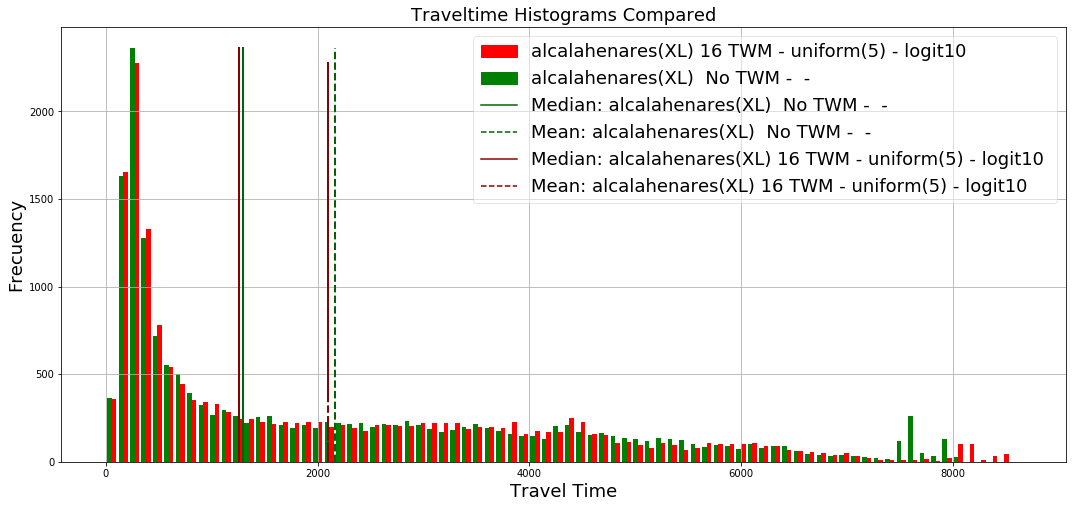

,,Stat,Units,confidence,Analysis,stat,pvalue
0,Travel Time,T-TEST,(t_stat)(p_value),0.05%,We cannot assure that variances are equal,stat=-0.06487223036883909,p_val=0.9482760987851474
1,Route Length,T-TEST,(t_stat)(p_value),0.05%,We cannot assure that variances are equal,stat=-1.8091527425678122,p_val=0.07043571819597276
2,Travel Time,Wilcoxon Paired RankSign,,0.05%,cannot reject that Medians are sensitive diffe...,stat=72427747.0,p_val=0.06044856602002496
3,Diff in Travel Time,Shapiro,,0.05%,We cannot assure that variances are equal,stat=-1.8091527425678122,p_val=0.07043571819597276
4,Travel Time Diff secs,Shapiro Normality,secs,0.05%,Distrib is not normal,,0
5,Travel Time Diff secs,mean,t.units,0.05%,gets worse,-1.4245,
6,Travel Time Diff secs,median,t.units,0.05%,hasn't changed,0,
7,Travel Time Diff secs,std.deviation,t.units,0.05%,has improved,791.282,
8,Travel Time Diff %,Shapiro Normality,%,,Distrib is not normal,,0
9,Travel Time Diff %,mean,%,,gets worse,-9.03756,


/Users/alvaro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


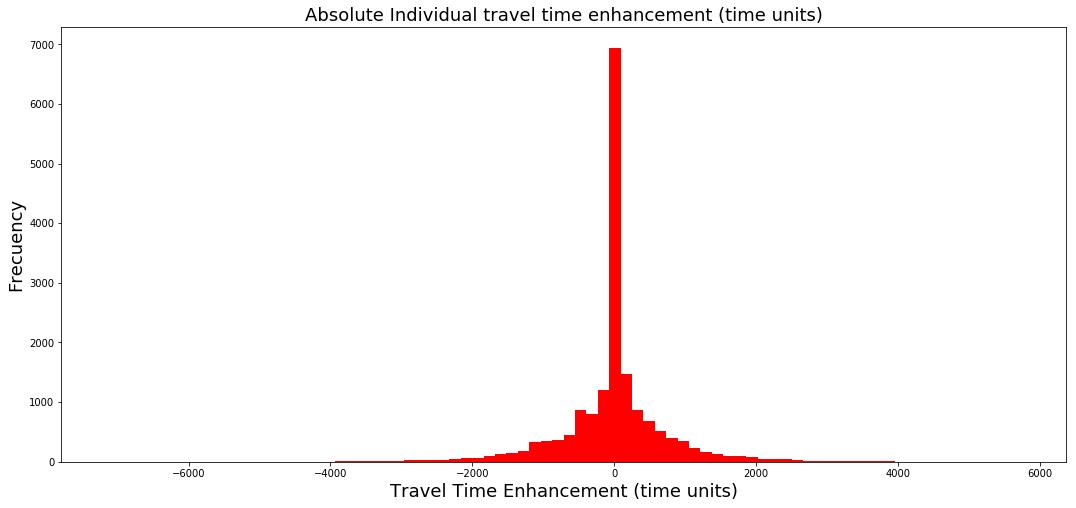

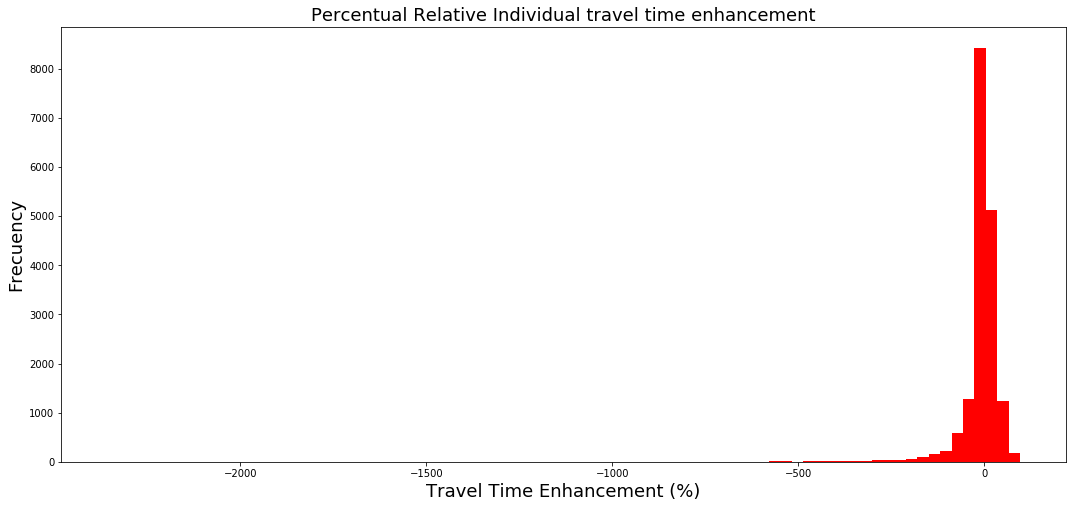

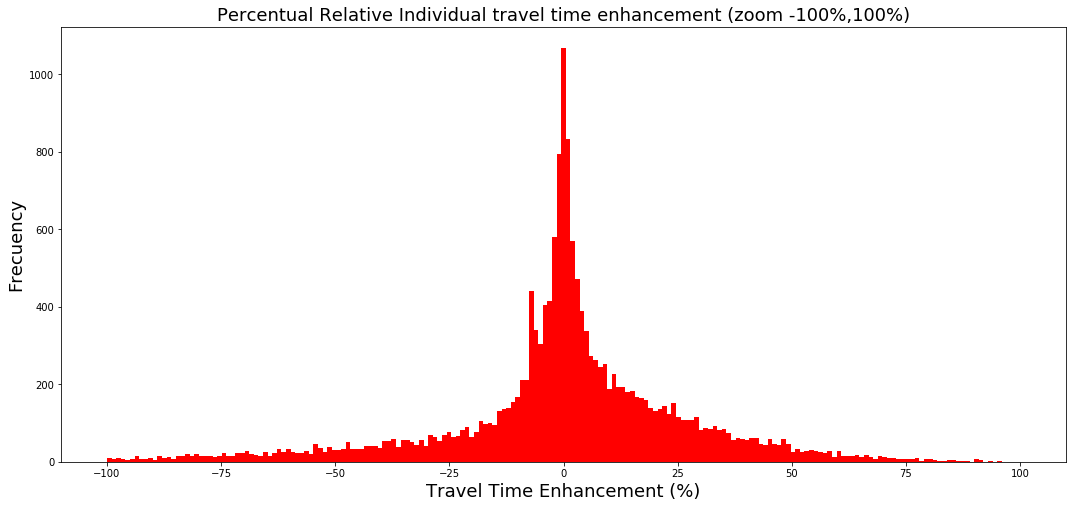

DUMPED FILE: OUTPUT/alcala_adh_XXXX.cumProb.csv for (-100,100)


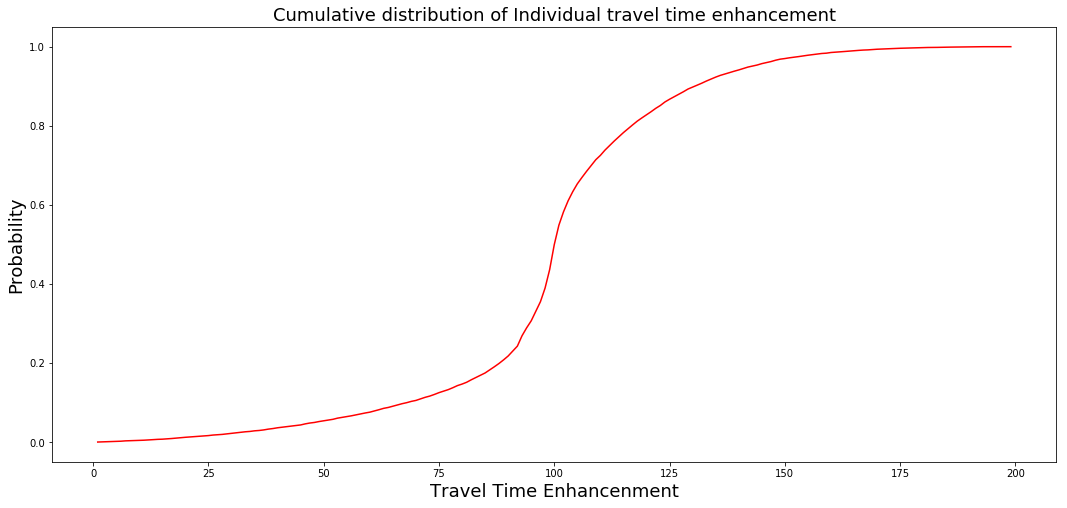

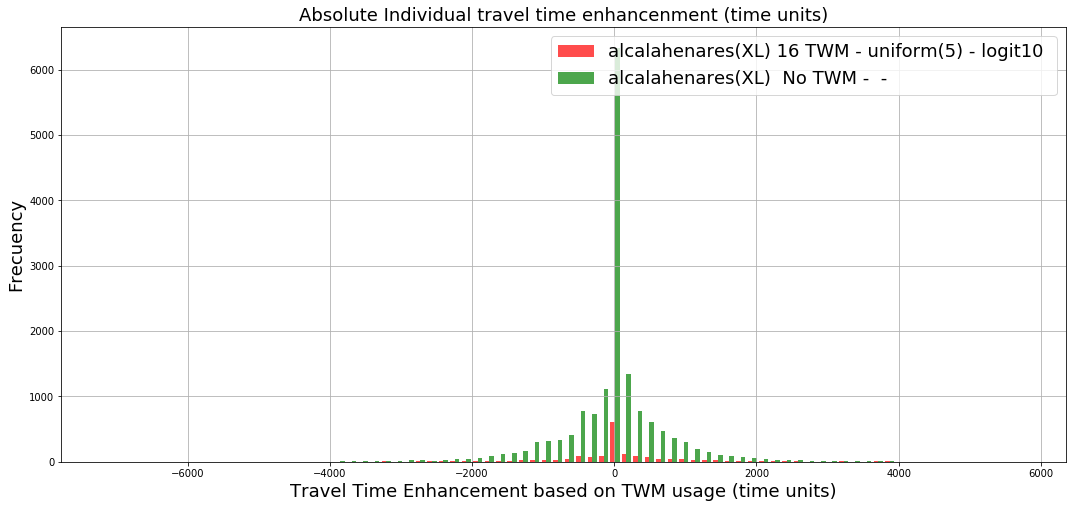

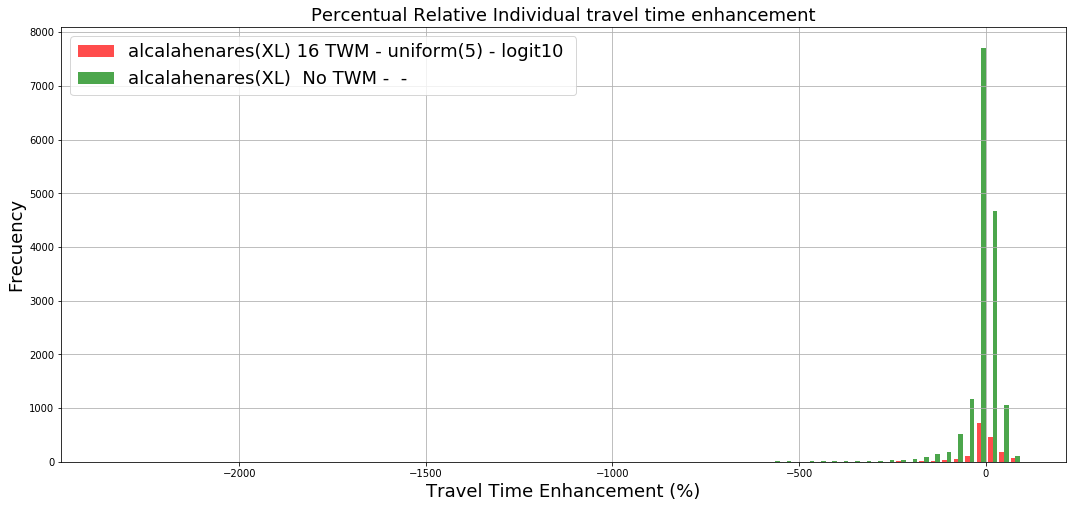

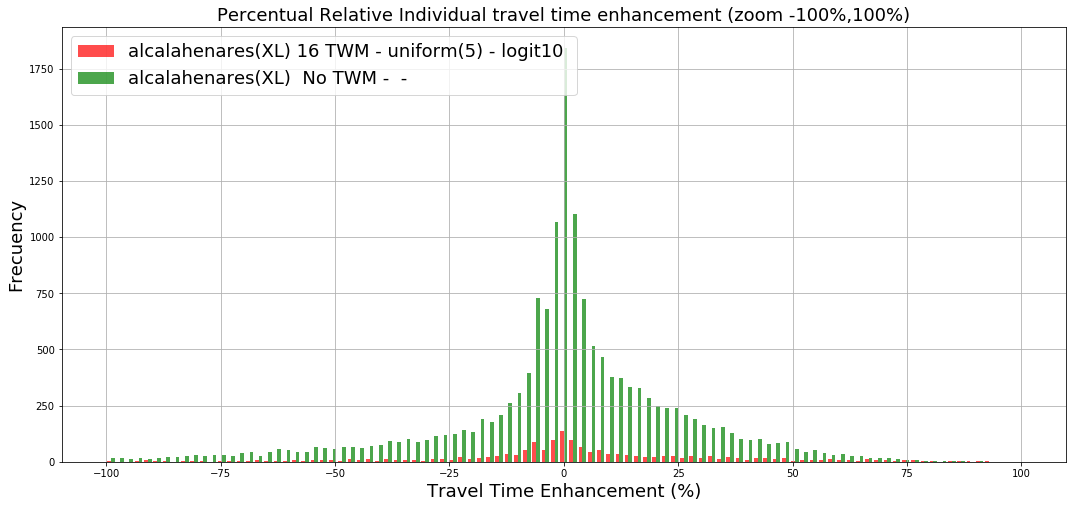

In [186]:
compare_scenarios( BASTRA_PATH, label1, experiment1, label2, experiment2 )

# BACKUP

In [11]:
# Bastra L con 1 mapa
exp[1]="grid16_noBastra_nomaps_fulltraffic_161114_125258"
exp[2]="grid16_Bastra_rand05x1_timeALL_fulltraffic_logit05_161114_131513"

# Extra-Large con 2 lanes por edge + con 8 mapas
exp[3]="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161114_190405"
exp[4]="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_183734"


# Small con 8 mapas
exp[5]="S_grid16_noBastra_reference_fulltraffic_161114_115215"
exp[6]="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161114_114837"
exp[7]="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_114102"

In [12]:
BASTRA_PATH="/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra"
label1="GRID16/MuTRAFF OFF/full traffic"
label2="GRID16/MuTRAFF ON/full traffic/1MAP/random5/logit100"

# Bastra L con 1 mapa
exp[7]="grid16_noBastra_nomaps_fulltraffic_161114_125258"
exp[8]="grid16_Bastra_rand05x1_timeALL_fulltraffic_logit05_161114_131513"

# Extra-Large con 2 lanes por edge + con 8 mapas
exp[9]="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161114_190405"
exp[10]="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_183734"


# Small con 8 mapas
exp[11]="S_grid16_noBastra_reference_fulltraffic_161114_115215"
exp[12]="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161114_114837"
exp[13]="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_114102"

In [13]:
# Experimento con los 8 mapas puestos = pesos de referencia --> deberia dar lo mismo que sin Bastra o con reference maps
exp[14]="S_grid16_noBastra_reference_fulltraffic_161114_115215"
exp[15]="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_194134"

In [14]:
# Extra-Small para no saturar y 8 mapas random (500 + 4x200)
exp[20]="XS_grid16_noBastra_reference_fulltraffic_170130_225044"
exp[21]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit10_161115_092404"
exp[22]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_170130_225435"

exp[23]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit05_161115_092039"
exp[24]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit10_161115_092404"
exp[25]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit20_161115_092738"
exp[26]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_093115"
exp[27]="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_093432"

exp[60]="XS_grid16_Bastra_rand2x8_timeALL_fulltraffic_logit20_190527_060828"
exp[61]="XS_grid16_Bastra_rand2x8_timeALL_fulltraffic_logit50_190527_061056"
exp[62]="XS_grid16_Bastra_rand05x4_timeALL_fulltraffic_logit20_190527_061308"
exp[63]="XS_grid16_Bastra_rand05x4_timeALL_fulltraffic_logit50_190527_061541"


In [15]:
# 2 LANES con trafico grid16 normal (3000 + 4x200)
#exp[30]="grid16_noBastra_reference_fulltraffic_161115_110544"
exp[30]="XL2_grid16_noBastra_reference_fulltraffic_161115_092630"
exp[31]="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_093151"
exp[32]="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_093621"


In [16]:
# 2 LANES con tráfico grid16 L (3000 + 4x200)
exp[33]="grid16_noBastra_reference_fulltraffic_161115_164807"

exp[34]="XL2_grid16_noBastra_reference_fulltraffic_161115_132611"
exp[35]="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_133434"
exp[36]="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_134312"

exp[37]="grid16_M_noTWM_reference_fulltraffic_190314_003326"
exp[38]="grid16_M_noTWM_reference_2lanes_fulltraffic_190314_003712"

In [17]:
# A* Routing algorithms comparison
exp[40]="grid16_noBastra_reference_fulltraffic_161115_192127"
exp[41]="grid16_noBastraAstar_reference_fulltraffic_161115_191754"
exp[42]="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit20_161115_222212"
exp[43]="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit50_161115_223541"
exp[44]="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit100_161115_225023"


In [18]:
# A* Routing algorithms comparison

# First experiments:
exp[50]="grid16_noBastra_reference_fulltraffic_161115_192127"
exp[51]="grid16_noBastraAstar_reference_fulltraffic_161115_191754"
#experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit20_161115_222212"
#experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit50_161115_223541"
#experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit100_161115_225023"

# Second experiments:
exp[52]="grid16_noBastraAstar_reference_fulltraffic_161115_191754"
exp[53]="grid16_noBastraAstar_reference_fulltraffic_161121_095357"
exp[54]="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit20_161121_100716"
# experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit50_161121_101535"
# experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit100_161121_102631"


In [19]:
# ALCALA DE HENARES EXPERIMENTS
# alcalahenares_noBastra_nomaps_fulltraffic_161216_110525
# alcalahenares_L_Bastra_uni1x8_timeALL_fulltraffic_logit50_161216_114129
# alcalahenares_L_Bastra_uni5x8_timeALL_fulltraffic_logit50_161216_121730
# alcalahenares_L_Bastra_uni5x16_timeALL_fulltraffic_logit50_161216_153926

exp[1004]="alcalahenares_noBastra_nomaps_fulltraffic_170115_230706"
exp[1005]="alcalahenares_noBastra_nomaps_fulltraffic_170115_230706"

exp[1000]="alcalahenares_noBastra_nomaps_tele300_fulltraffic_170116_000420"
exp[1001]="alcalahenares_L_Bastra_tele300_uni5x8_timeALL_fulltraffic_logit50_170116_004127"
exp[1002]="alcalahenares_L_Bastra_tele300_uni1x8_timeALL_fulltraffic_logit50_170116_002314"
exp[1003]="alcalahenares_L_Bastra_tele300_uni5x16_timeALL_fulltraffic_logit50_170116_005920"

exp[1100]="alcalahenares_noBastra_nomaps_tele60_fulltraffic_170126_201242"
exp[1101]="alcalahenares_L_Bastra_tele60_uni1x8_timeALL_fulltraffic_logit50_170126_203035"
exp[1102]="alcalahenares_L_Bastra_tele60_uni5x16_timeALL_fulltraffic_logit50_170126_204811"
exp[1103]="alcalahenares_L_Bastra_tele60_uni5x8_timeALL_fulltraffic_logit50_170126_210456"

set_experiments(1000,1001)

In [20]:
# RADIAL16 EXPERIMENTS
exp[500]="radial16_noBastra_XXS_fulltraffic_170111_232306"
exp[501]="radial16_noBastra_XS_fulltraffic_170111_232346"
exp[502]="radial16_noBastra_S_fulltraffic_170111_232444"
exp[503]="radial16_noBastra_M2_fulltraffic_170111_232549"
exp[504]="radial16_noBastra_M_fulltraffic_170111_233225"
exp[505]="radial16_noBastra_L_fulltraffic_170111_233357"
exp[506]="radial16_noBastra_XL2_fulltraffic_170111_234332"
exp[507]="radial16_XS_Bastra_rand05x1_timeALL_fulltraffic_logit05_170111_235743"
exp[508]="radial16_XS_Bastra_rand05x1_timeALL_fulltraffic_logit10_170111_235839"
exp[509]="radial16_XS_Bastra_rand05x1_timeALL_fulltraffic_logit100_170111_235936"
exp[510]="radial16_XS_Bastra_rand05x1_timeALL_fulltraffic_logit20_170112_000036"
exp[511]="radial16_XS_Bastra_rand05x1_timeALL_fulltraffic_logit50_170112_000133"
exp[512]="radial16_XS_Bastra_rand05x2_timeALL_fulltraffic_logit05_170112_000228"
exp[513]="radial16_XS_Bastra_rand05x2_timeALL_fulltraffic_logit10_170112_000324"
exp[514]="radial16_XS_Bastra_rand05x2_timeALL_fulltraffic_logit100_170112_000420"
exp[515]="radial16_XS_Bastra_rand05x2_timeALL_fulltraffic_logit20_170112_000519"
exp[516]="radial16_XS_Bastra_rand05x2_timeALL_fulltraffic_logit50_170112_000615"
exp[517]="radial16_XS_Bastra_rand05x4_timeALL_fulltraffic_logit05_170112_000713"
exp[518]="radial16_XS_Bastra_rand05x4_timeALL_fulltraffic_logit10_170112_000809"
exp[519]="radial16_XS_Bastra_rand05x4_timeALL_fulltraffic_logit100_170112_000905"
exp[520]="radial16_XS_Bastra_rand05x4_timeALL_fulltraffic_logit20_170112_001004"
exp[521]="radial16_XS_Bastra_rand05x4_timeALL_fulltraffic_logit50_170112_001101"
exp[522]="radial16_M2_Bastra_rand05x1_timeALL_fulltraffic_logit05_170112_001329"
exp[523]="radial16_M2_Bastra_rand05x1_timeALL_fulltraffic_logit10_170112_001438"
exp[524]="radial16_M2_Bastra_rand05x1_timeALL_fulltraffic_logit100_170112_001545"
exp[525]="radial16_M2_Bastra_rand05x1_timeALL_fulltraffic_logit20_170112_001658"
exp[526]="radial16_M2_Bastra_rand05x1_timeALL_fulltraffic_logit50_170112_001806"
exp[527]="radial16_M2_Bastra_rand05x2_timeALL_fulltraffic_logit05_170112_001917"
exp[528]="radial16_M2_Bastra_rand05x2_timeALL_fulltraffic_logit10_170112_002030"
exp[529]="radial16_M2_Bastra_rand05x2_timeALL_fulltraffic_logit100_170112_002142"
exp[530]="radial16_M2_Bastra_rand05x2_timeALL_fulltraffic_logit20_170112_002259"
exp[531]="radial16_M2_Bastra_rand05x2_timeALL_fulltraffic_logit50_170112_002412"
exp[532]="radial16_M2_Bastra_rand05x4_timeALL_fulltraffic_logit05_170112_002526"
exp[533]="radial16_M2_Bastra_rand05x4_timeALL_fulltraffic_logit10_170112_002638"
exp[534]="radial16_M2_Bastra_rand05x4_timeALL_fulltraffic_logit100_170112_002750"
exp[535]="radial16_M2_Bastra_rand05x4_timeALL_fulltraffic_logit20_170112_002905"
exp[536]="radial16_M2_Bastra_rand05x4_timeALL_fulltraffic_logit50_170112_003018"
exp[537]="radial16_M2_Bastra_rand05x8_timeALL_fulltraffic_logit05_170112_003130"
exp[538]="radial16_M2_Bastra_rand05x8_timeALL_fulltraffic_logit10_170112_003240"
exp[539]="radial16_M2_Bastra_rand05x8_timeALL_fulltraffic_logit100_170112_003349"
exp[540]="radial16_M2_Bastra_rand05x8_timeALL_fulltraffic_logit20_170112_003506"
exp[541]="radial16_M2_Bastra_rand05x8_timeALL_fulltraffic_logit50_170112_003615"
exp[542]="radial16_M2_Bastra_rand2x2_timeALL_fulltraffic_logit05_170112_003728"
exp[543]="radial16_M2_Bastra_rand2x2_timeALL_fulltraffic_logit10_170112_003838"
exp[544]="radial16_M2_Bastra_rand2x2_timeALL_fulltraffic_logit100_170112_003947"
exp[545]="radial16_M2_Bastra_rand2x2_timeALL_fulltraffic_logit20_170112_004101"
exp[546]="radial16_M2_Bastra_rand2x2_timeALL_fulltraffic_logit50_170112_004212"
exp[547]="radial16_M2_Bastra_rand2x4_timeALL_fulltraffic_logit05_170112_004323"
exp[548]="radial16_M2_Bastra_rand2x4_timeALL_fulltraffic_logit10_170112_004432"
exp[549]="radial16_M2_Bastra_rand2x4_timeALL_fulltraffic_logit100_170112_004542"
exp[550]="radial16_M2_Bastra_rand2x4_timeALL_fulltraffic_logit20_170112_004656"
exp[551]="radial16_M2_Bastra_rand2x4_timeALL_fulltraffic_logit50_170112_004805"
exp[552]="radial16_M_Bastra_rand05x1_timeALL_fulltraffic_logit05_170112_004917"
exp[553]="radial16_M_Bastra_rand05x1_timeALL_fulltraffic_logit10_170112_005041"
exp[554]="radial16_M_Bastra_rand05x1_timeALL_fulltraffic_logit100_170112_005207"
exp[555]="radial16_M_Bastra_rand05x1_timeALL_fulltraffic_logit20_170112_005329"
exp[556]="radial16_M_Bastra_rand05x1_timeALL_fulltraffic_logit50_170112_005450"
exp[557]="radial16_M_Bastra_rand05x2_timeALL_fulltraffic_logit05_170112_005609"
exp[558]="radial16_M_Bastra_rand05x2_timeALL_fulltraffic_logit10_170112_005733"
exp[559]="radial16_M_Bastra_rand05x2_timeALL_fulltraffic_logit100_170112_005856"
exp[560]="radial16_M_Bastra_rand05x2_timeALL_fulltraffic_logit20_170112_010018"
exp[561]="radial16_M_Bastra_rand05x2_timeALL_fulltraffic_logit50_170112_010144"
exp[562]="radial16_M_Bastra_rand05x4_timeALL_fulltraffic_logit05_170112_010301"
exp[563]="radial16_M_Bastra_rand05x4_timeALL_fulltraffic_logit10_170112_010426"
exp[564]="radial16_M_Bastra_rand05x4_timeALL_fulltraffic_logit100_170112_010551"
exp[565]="radial16_M_Bastra_rand05x4_timeALL_fulltraffic_logit20_170112_010710"
exp[566]="radial16_M_Bastra_rand05x4_timeALL_fulltraffic_logit50_170112_010832"
exp[567]="radial16_M_Bastra_rand05x8_timeALL_fulltraffic_logit05_170112_010953"
exp[568]="radial16_M_Bastra_rand05x8_timeALL_fulltraffic_logit10_170112_011121"
exp[569]="radial16_M_Bastra_rand05x8_timeALL_fulltraffic_logit100_170112_011245"
exp[570]="radial16_M_Bastra_rand05x8_timeALL_fulltraffic_logit20_170112_011407"
exp[571]="radial16_M_Bastra_rand05x8_timeALL_fulltraffic_logit50_170112_011530"
exp[572]="radial16_M_Bastra_rand2x2_timeALL_fulltraffic_logit05_170112_011650"
exp[573]="radial16_M_Bastra_rand2x2_timeALL_fulltraffic_logit10_170112_011812"
exp[574]="radial16_M_Bastra_rand2x2_timeALL_fulltraffic_logit100_170112_011939"
exp[575]="radial16_M_Bastra_rand2x2_timeALL_fulltraffic_logit20_170112_012101"
exp[576]="radial16_M_Bastra_rand2x2_timeALL_fulltraffic_logit50_170112_012223"
exp[577]="radial16_M_Bastra_rand2x4_timeALL_fulltraffic_logit05_170112_012345"
exp[578]="radial16_M_Bastra_rand2x4_timeALL_fulltraffic_logit10_170112_012510"
exp[579]="radial16_M_Bastra_rand2x4_timeALL_fulltraffic_logit100_170112_012636"
exp[580]="radial16_M_Bastra_rand2x4_timeALL_fulltraffic_logit20_170112_012802"
exp[581]="radial16_M_Bastra_rand2x4_timeALL_fulltraffic_logit50_170112_012930"
exp[582]="radial16_L_Bastra_rand05x1_timeALL_fulltraffic_logit05_170112_013056"
exp[583]="radial16_L_Bastra_rand05x1_timeALL_fulltraffic_logit10_170112_013341"
exp[584]="radial16_L_Bastra_rand05x1_timeALL_fulltraffic_logit100_170112_014126"
exp[585]="radial16_L_Bastra_rand05x1_timeALL_fulltraffic_logit20_170112_014538"
exp[586]="radial16_L_Bastra_rand05x1_timeALL_fulltraffic_logit50_170112_015044"
exp[587]="radial16_L_Bastra_rand05x2_timeALL_fulltraffic_logit05_170112_015238"
exp[588]="radial16_L_Bastra_rand05x2_timeALL_fulltraffic_logit10_170112_015517"
exp[589]="radial16_L_Bastra_rand05x2_timeALL_fulltraffic_logit100_170112_015750"
exp[590]="radial16_L_Bastra_rand05x2_timeALL_fulltraffic_logit20_170112_015935"
exp[591]="radial16_L_Bastra_rand05x2_timeALL_fulltraffic_logit50_170112_020159"
exp[592]="radial16_L_Bastra_rand05x4_timeALL_fulltraffic_logit05_170112_021001"
exp[593]="radial16_L_Bastra_rand05x4_timeALL_fulltraffic_logit10_170112_021256"
exp[594]="radial16_L_Bastra_rand05x4_timeALL_fulltraffic_logit100_170112_021533"
exp[595]="radial16_L_Bastra_rand05x4_timeALL_fulltraffic_logit20_170112_021720"
exp[596]="radial16_L_Bastra_rand05x4_timeALL_fulltraffic_logit50_170112_022433"
exp[597]="radial16_L_Bastra_rand05x8_timeALL_fulltraffic_logit05_170112_022635"
exp[598]="radial16_L_Bastra_rand05x8_timeALL_fulltraffic_logit10_170112_022915"
exp[599]="radial16_L_Bastra_rand05x8_timeALL_fulltraffic_logit100_170112_023151"
exp[600]="radial16_L_Bastra_rand05x8_timeALL_fulltraffic_logit20_170112_023348"
exp[601]="radial16_L_Bastra_rand05x8_timeALL_fulltraffic_logit50_170112_023634"
exp[602]="radial16_L_Bastra_rand2x2_timeALL_fulltraffic_logit05_170112_023841"
exp[603]="radial16_L_Bastra_rand2x2_timeALL_fulltraffic_logit10_170112_024334"
exp[604]="radial16_L_Bastra_rand2x2_timeALL_fulltraffic_logit100_170112_024609"
exp[605]="radial16_L_Bastra_rand2x2_timeALL_fulltraffic_logit20_170112_024808"
exp[606]="radial16_L_Bastra_rand2x2_timeALL_fulltraffic_logit50_170112_025416"
exp[607]="radial16_L_Bastra_rand2x4_timeALL_fulltraffic_logit05_170112_025627"
exp[608]="radial16_L_Bastra_rand2x4_timeALL_fulltraffic_logit10_170112_025912"
exp[609]="radial16_L_Bastra_rand2x4_timeALL_fulltraffic_logit100_170112_030549"
exp[610]="radial16_L_Bastra_rand2x4_timeALL_fulltraffic_logit20_170112_030740"
exp[611]="radial16_L_Bastra_rand2x4_timeALL_fulltraffic_logit50_170112_031439"
exp[612]="radial16_XL2_Bastra_rand05x1_timeALL_fulltraffic_logit05_170112_032025"
exp[613]="radial16_XL2_Bastra_rand05x1_timeALL_fulltraffic_logit10_170112_033553"
exp[614]="radial16_XL2_Bastra_rand05x1_timeALL_fulltraffic_logit100_170112_035126"
exp[615]="radial16_XL2_Bastra_rand05x1_timeALL_fulltraffic_logit20_170112_040946"
exp[616]="radial16_XL2_Bastra_rand05x1_timeALL_fulltraffic_logit50_170112_042434"
exp[617]="radial16_XL2_Bastra_rand05x2_timeALL_fulltraffic_logit05_170112_044047"
exp[618]="radial16_XL2_Bastra_rand05x2_timeALL_fulltraffic_logit10_170112_045651"
exp[619]="radial16_XL2_Bastra_rand05x2_timeALL_fulltraffic_logit100_170112_051128"
exp[620]="radial16_XL2_Bastra_rand05x2_timeALL_fulltraffic_logit20_170112_052741"
exp[621]="radial16_XL2_Bastra_rand05x2_timeALL_fulltraffic_logit50_170112_054329"
exp[622]="radial16_XL2_Bastra_rand05x4_timeALL_fulltraffic_logit05_170112_055700"
exp[623]="radial16_XL2_Bastra_rand05x4_timeALL_fulltraffic_logit10_170112_061213"
exp[624]="radial16_XL2_Bastra_rand05x4_timeALL_fulltraffic_logit100_170112_062626"
exp[625]="radial16_XL2_Bastra_rand05x4_timeALL_fulltraffic_logit20_170112_064052"
exp[626]="radial16_XL2_Bastra_rand05x4_timeALL_fulltraffic_logit50_170112_065703"
exp[627]="radial16_XL2_Bastra_rand05x8_timeALL_fulltraffic_logit05_170112_094500"
exp[628]="radial16_XL2_Bastra_rand05x8_timeALL_fulltraffic_logit10_170112_142512"
exp[629]="radial16_XL2_Bastra_rand05x8_timeALL_fulltraffic_logit100_170112_144117"
exp[630]="radial16_XL2_Bastra_rand05x8_timeALL_fulltraffic_logit20_170112_145550"
exp[631]="radial16_XL2_Bastra_rand05x8_timeALL_fulltraffic_logit50_170112_150929"
exp[632]="radial16_XL2_Bastra_rand2x2_timeALL_fulltraffic_logit05_170112_152321"
exp[633]="radial16_XL2_Bastra_rand2x2_timeALL_fulltraffic_logit10_170112_153713"
exp[634]="radial16_XL2_Bastra_rand2x2_timeALL_fulltraffic_logit100_170112_155127"
exp[635]="radial16_XL2_Bastra_rand2x2_timeALL_fulltraffic_logit20_170112_160558"
exp[636]="radial16_XL2_Bastra_rand2x2_timeALL_fulltraffic_logit50_170112_162104"
exp[637]="radial16_XL2_Bastra_rand2x4_timeALL_fulltraffic_logit05_170112_163311"
exp[638]="radial16_XL2_Bastra_rand2x4_timeALL_fulltraffic_logit10_170112_164810"
exp[639]="radial16_XL2_Bastra_rand2x4_timeALL_fulltraffic_logit100_170112_170303"
exp[640]="radial16_XL2_Bastra_rand2x4_timeALL_fulltraffic_logit20_170112_171722"
exp[641]="radial16_XL2_Bastra_rand2x4_timeALL_fulltraffic_logit50_170112_173237"

# -L- time-to-teleport = 30
exp[642]="radial16_noBastra_L_fulltraffic_170115_222202"  
exp[643]="radial16_L_Bastra_rand05x8_timeALL_fulltraffic_logit50_170115_222455"

# -XL- time-to-teleport = 30
exp[644]="radial16_noBastra_XL2_fulltraffic_170115_223107"  
exp[645]="radial16_XL2_Bastra_rand05x8_timeALL_fulltraffic_logit50_170115_223333"

# XXL
exp[646]="radial16_noBastra_XXL_fulltraffic_170115_225021"
exp[647]="radial16_noBastra_XXL_fulltraffic_170115_225722"

# TELEPORTING time-to-teleport = 30
exp[650]="radial16_XXL_noBastra_nomaps_fulltraffic_170125_231820"
exp[651]="radial16_XXL_Bastra_rand05x1_timeALL_fulltraffic_logit50_170116_002248"
exp[652]="radial16_XXL_Bastra_rand05x1_timeALL_fulltraffic_logit100_170116_002704"
exp[653]="radial16_XXL_Bastra_rand05x2_timeALL_fulltraffic_logit05_170116_003203"
exp[654]="radial16_XXL_Bastra_rand05x2_timeALL_fulltraffic_logit10_170116_003557"
exp[655]="radial16_XXL_Bastra_rand05x2_timeALL_fulltraffic_logit20_170116_003955"
exp[656]="radial16_XXL_Bastra_rand05x2_timeALL_fulltraffic_logit50_170116_004349"
exp[657]="radial16_XXL_Bastra_rand05x2_timeALL_fulltraffic_logit100_170116_004745"
exp[658]="radial16_XXL_Bastra_rand05x4_timeALL_fulltraffic_logit05_170116_005211"
exp[659]="radial16_XXL_Bastra_rand05x4_timeALL_fulltraffic_logit10_170116_005608"
exp[660]="radial16_XXL_Bastra_rand05x4_timeALL_fulltraffic_logit20_170116_010004"
exp[661]="radial16_XXL_Bastra_rand05x4_timeALL_fulltraffic_logit50_170116_010403"
exp[662]="radial16_XXL_Bastra_rand05x4_timeALL_fulltraffic_logit100_170116_010801"
exp[663]="radial16_XXL_Bastra_rand05x8_timeALL_fulltraffic_logit05_170116_011219"
exp[664]="radial16_XXL_Bastra_rand05x8_timeALL_fulltraffic_logit10_170116_011614"
exp[665]="radial16_XXL_Bastra_rand05x8_timeALL_fulltraffic_logit20_170116_012003"
exp[666]="radial16_XXL_Bastra_rand05x8_timeALL_fulltraffic_logit50_170116_012354"
exp[667]="radial16_XXL_Bastra_rand05x8_timeALL_fulltraffic_logit100_170116_012754"
exp[668]="radial16_XXL_Bastra_rand2x2_timeALL_fulltraffic_logit05_170116_013208"
exp[669]="radial16_XXL_Bastra_rand2x2_timeALL_fulltraffic_logit10_170116_013601"
exp[670]="radial16_XXL_Bastra_rand2x2_timeALL_fulltraffic_logit20_170116_013948"
exp[671]="radial16_XXL_Bastra_rand2x2_timeALL_fulltraffic_logit50_170116_014335"
exp[672]="radial16_XXL_Bastra_rand2x2_timeALL_fulltraffic_logit100_170116_014731"
exp[673]="radial16_XXL_Bastra_rand2x4_timeALL_fulltraffic_logit05_170116_015152"
exp[674]="radial16_XXL_Bastra_rand2x4_timeALL_fulltraffic_logit10_170116_015539"
exp[675]="radial16_XXL_Bastra_rand2x4_timeALL_fulltraffic_logit20_170116_015928"
exp[676]="radial16_XXL_Bastra_rand2x4_timeALL_fulltraffic_logit50_170116_020315"
exp[677]="radial16_XXL_Bastra_rand2x4_timeALL_fulltraffic_logit100_170116_020708"

# TELEPORT - time-to-teleport=60
exp[700]="radial16_XXL_noBastra_tele60_nomaps_fulltraffic_170125_234213"
exp[701]="radial16_XXL_Bastra_tele60_rand05x8_timeALL_fulltraffic_logit50_170125_234652"
exp[702]="radial16_XXL_Bastra_tele60_rand05x2_timeALL_fulltraffic_logit50_170125_235111"
exp[703]="radial16_XXL_Bastra_tele60_rand05x1_timeALL_fulltraffic_logit05_170125_235649"
exp[704]="radial16_XXL_Bastra_tele60_rand05x1_timeALL_fulltraffic_logit10_170126_000104"
exp[705]="radial16_XXL_Bastra_tele60_rand05x1_timeALL_fulltraffic_logit20_170126_000516"
exp[706]="radial16_XXL_Bastra_tele60_rand05x1_timeALL_fulltraffic_logit50_170126_000928"
exp[707]="radial16_XXL_Bastra_tele60_rand05x1_timeALL_fulltraffic_logit100_170126_001405"
exp[708]="radial16_XXL_Bastra_tele60_rand05x2_timeALL_fulltraffic_logit05_170126_001957"
exp[709]="radial16_XXL_Bastra_tele60_rand05x2_timeALL_fulltraffic_logit10_170126_002412"
exp[710]="radial16_XXL_Bastra_tele60_rand05x2_timeALL_fulltraffic_logit20_170126_002829"
exp[711]="radial16_XXL_Bastra_tele60_rand05x2_timeALL_fulltraffic_logit100_170126_003238"
exp[712]="radial16_XXL_Bastra_tele60_rand05x4_timeALL_fulltraffic_logit05_170126_003745"
exp[713]="radial16_XXL_Bastra_tele60_rand05x4_timeALL_fulltraffic_logit10_170126_004200"
exp[714]="radial16_XXL_Bastra_tele60_rand05x4_timeALL_fulltraffic_logit20_170126_004614"
exp[715]="radial16_XXL_Bastra_tele60_rand05x4_timeALL_fulltraffic_logit50_170126_005025"
exp[716]="radial16_XXL_Bastra_tele60_rand05x4_timeALL_fulltraffic_logit100_170126_005440"
exp[717]="radial16_XXL_Bastra_tele60_rand05x8_timeALL_fulltraffic_logit05_170126_005920"
exp[718]="radial16_XXL_Bastra_tele60_rand05x8_timeALL_fulltraffic_logit10_170126_010340"
exp[719]="radial16_XXL_Bastra_tele60_rand05x8_timeALL_fulltraffic_logit20_170126_010753"
exp[720]="radial16_XXL_Bastra_tele60_rand05x8_timeALL_fulltraffic_logit100_170126_011207"
exp[721]="radial16_XXL_Bastra_tele60_rand2x2_timeALL_fulltraffic_logit05_170126_011634"
exp[722]="radial16_XXL_Bastra_tele60_rand2x2_timeALL_fulltraffic_logit10_170126_012047"
exp[723]="radial16_XXL_Bastra_tele60_rand2x2_timeALL_fulltraffic_logit20_170126_012501"
exp[724]="radial16_XXL_Bastra_tele60_rand2x2_timeALL_fulltraffic_logit50_170126_012914"
exp[725]="radial16_XXL_Bastra_tele60_rand2x2_timeALL_fulltraffic_logit100_170126_013333"
exp[726]="radial16_XXL_Bastra_tele60_rand2x4_timeALL_fulltraffic_logit05_170126_013852"
exp[727]="radial16_XXL_Bastra_tele60_rand2x4_timeALL_fulltraffic_logit10_170126_014309"
exp[728]="radial16_XXL_Bastra_tele60_rand2x4_timeALL_fulltraffic_logit20_170126_014723"
exp[729]="radial16_XXL_Bastra_tele60_rand2x4_timeALL_fulltraffic_logit50_170126_015141"

In [44]:
# ALCALA DE HENARES EXPERIMENTS
# alcalahenares_noBastra_nomaps_fulltraffic_161216_110525
# alcalahenares_L_Bastra_uni1x8_timeALL_fulltraffic_logit50_161216_114129
# alcalahenares_L_Bastra_uni5x8_timeALL_fulltraffic_logit50_161216_121730
# alcalahenares_L_Bastra_uni5x16_timeALL_fulltraffic_logit50_161216_153926

experiment1="alcalahenares_noBastra_nomaps_fulltraffic_170115_230706"
experiment2="alcalahenares_noBastra_nomaps_fulltraffic_170115_230706"

exp[1000]="alcalahenares_noBastra_nomaps_tele300_fulltraffic_170116_000420"
exp[1001]="alcalahenares_L_Bastra_tele300_uni5x8_timeALL_fulltraffic_logit50_170116_004127"
exp[1002]="alcalahenares_L_Bastra_tele300_uni1x8_timeALL_fulltraffic_logit50_170116_002314"
exp[1003]="alcalahenares_L_Bastra_tele300_uni5x16_timeALL_fulltraffic_logit50_170116_005920"

exp[1100]="alcalahenares_noBastra_nomaps_tele60_fulltraffic_170126_201242"
exp[1101]="alcalahenares_L_Bastra_tele60_uni1x8_timeALL_fulltraffic_logit50_170126_203035"
exp[1102]="alcalahenares_L_Bastra_tele60_uni5x16_timeALL_fulltraffic_logit50_170126_204811"
exp[1103]="alcalahenares_L_Bastra_tele60_uni5x8_timeALL_fulltraffic_logit50_170126_210456"

exp[1150]="alcalahenares_XL_nomutraff_tele60_nomaps_fulltraffic_170130_200632"
exp[1151]="alcalahenares_XL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit10_170130_202418"
exp[1152]="alcalahenares_XL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit20_170130_222842"
exp[1153]="alcalahenares_XL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit50_170131_002856"
exp[1154]="alcalahenares_XL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit100_170131_022031"
exp[1155]="alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10_170131_040937"
exp[1156]="alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit20_170131_061125"
exp[1157]="alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_170131_081200"
exp[1158]="alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit100_170131_100628"
exp[1159]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit10_170131_120427"
exp[1160]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit20_170131_140843"
exp[1161]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_170131_161749"
exp[1162]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit100_170131_180507"

exp[1170]="alcalahenares_XL_nomutraff_tele60_nomaps_fulltraffic_170206_085516"
exp[1171]="alcalahenares_XL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit10_170206_101837"
exp[1172]="alcalahenares_XL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit20_170206_113945"
exp[1173]="alcalahenares_XL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit50_170206_130158"
exp[1174]="alcalahenares_XL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit100_170206_141519"
exp[1175]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit10_170206_153012"
exp[1176]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit20_170206_165216"
exp[1177]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_170206_181328"
exp[1178]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit100_170206_193055"
exp[1179]="alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10_170206_204057"
exp[1180]="alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit20_170206_220415"
exp[1181]="alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_170206_232354"
exp[1182]="alcalahenares_XL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit100_170207_004023"


exp[1200]="alcalahenares_XXL_noBastra_tele60_nomaps_fulltraffic_170129_072912"
exp[1201]="alcalahenares_XXL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit10_170129_091235"
exp[1202]="alcalahenares_XXL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit10_170129_120212"
exp[1203]="alcalahenares_XXL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10_170129_144702"
exp[1204]="alcalahenares_XXL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit20_170129_173323"
exp[1205]="alcalahenares_XXL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit20_170129_201805"
exp[1206]="alcalahenares_XXL_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit20_170129_230412"
exp[1207]="alcalahenares_XXL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_170130_014946"
exp[1208]="alcalahenares_XXL_mutraff_tele60_uni1x8_timeALL_fulltraffic_logit100_170130_043133"
exp[1209]="alcalahenares_XXL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit100_170130_071541"

In [45]:
exp[1210]="radial16_noBastra_XXXL_fulltraffic_181021_123147"
exp[1211]="radial16_XXXL_Bastra_nomaps_fulltraffic_logit50_181021_124339"
exp[1212]="radial16_XXXL_Bastra_rand05x8_timeALL_fulltraffic_logit05_181021_171052"
exp[1213]="radial16_XXXL_Bastra_rand05x8_timeALL_fulltraffic_logit10_181021_172210"
exp[1214]="radial16_XXXL_Bastra_rand05x8_timeALL_fulltraffic_logit20_181021_214113"
exp[1215]="radial16_XXXL_Bastra_rand05x8_timeALL_fulltraffic_logit50_181021_125449"
exp[1216]="radial16_XXXL_Bastra_rand05x8_timeALL_fulltraffic_logit100_181021_215241"
exp[1217]="radial16_XXXL_Bastra_rand05x2_timeALL_fulltraffic_logit50_181021_220642"
exp[1218]="radial16_XXXL_Bastra_rand05x1_timeALL_fulltraffic_logit50_181021_221936"
exp[1219]="radial16_XXXL_Bastra_rand05x4_timeALL_fulltraffic_logit50_181021_223318"


In [47]:
exp[1250]="madrid_barrio_salamanca_L_nomaps_tele60_fulltrafic_181025_181150"
exp[1251]="madrid_barrio_salamanca_L_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit20_181025_183912"
exp[1252]="madrid_barrio_salamanca_L_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit50_181025_185614"
exp[1253]="madrid_barrio_salamanca_L_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit100_181025_191339"

exp[1260]="madrid_las_tablas_L_nomaps_tele60_fulltrafic_181025_182850"
exp[1261]="madrid_las_tablas_L_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit100_181025_200125"
exp[1262]="madrid_las_tablas_L_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit20_181025_194819"
exp[1263]="madrid_las_tablas_L_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit50_181025_195445"
exp[1264]="madrid_las_tablas_L_Bastra_uni5x8_timeALL_tele60_fulltrafic_logit50_181025_200815"

exp[1265]="madrid_las_tablas_M_nomaps_tele60_fulltrafic_190207_004643"
exp[1266]="madrid_las_tablas_M_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit20_190207_005208"
exp[1267]="madrid_las_tablas_M_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit50_190207_005725"
exp[1268]="madrid_las_tablas_M_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit100_190207_010238"
exp[1269]="madrid_las_tablas_M_Bastra_uni5x8_timeALL_tele60_fulltrafic_logit50_190207_010753"

exp[1270]="madrid_las_tablas_M_nomaps_tele60_fulltrafic_190207_080052"

exp[1271]="madrid_las_tablas_M_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit20_190207_080704"
exp[1272]="madrid_las_tablas_M_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit50_190207_081306"
exp[1273]="madrid_las_tablas_M_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit100_190207_081914"

exp[1274]="madrid_las_tablas_M_Bastra_rand2x8_timeALL_tele60_fulltrafic_logit20_190213_165924"
exp[1275]="madrid_las_tablas_M_Bastra_rand2x8_timeALL_tele60_fulltrafic_logit50_190213_170525"
exp[1276]="madrid_las_tablas_M_Bastra_rand2x8_timeALL_tele60_fulltrafic_logit100_190213_171130"

exp[1279]="madrid_las_tablas_M_Bastra_uni5x8_timeALL_tele60_fulltrafic_logit50_190207_082532"

exp[1280]="madrid_retiro_L_nomaps_tele60_fulltrafic_181025_183528"

In [48]:
exp[1300]="madrid_barrio_salamanca_M_nomaps_tele60_fulltrafic_181025_203259"
exp[1301]="madrid_barrio_salamanca_L_Bastra_rand05x8_timeALL_tele60_fulltrafic_logit50_181025_203822"

In [57]:
exp[2000]="alcalahenares_M_nomaps_tele60_timeALL_fulltraffic_190505_231438"
exp[2001]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190502_234402"
exp[2002]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_02_190503_083619"
exp[2003]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_03_190503_085940"
exp[2004]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_04_190503_160402"
exp[2005]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_05_190503_162735"
exp[2006]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_06_190503_165102"
exp[2007]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_07_190503_171425"
exp[2008]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_08_190503_173752"
exp[2009]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_09_190503_180119"
exp[2010]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_10_190503_182443"
exp[2011]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_11_190503_184802"
exp[2012]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_12_190503_191134"
exp[2013]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_13_190503_193505"
exp[2014]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_14_190503_195823"
exp[2015]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_15_190503_202145"
exp[2016]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_16_190503_204516"
exp[2017]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_17_190503_210835"
exp[2018]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_18_190503_213150"
exp[2019]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_19_190503_215518"
exp[2020]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_20_190503_221838"
exp[2025]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_MEANS"

exp[2050]="alcalahenares_M_nomaps_tele60_timeALL_fulltraffic_190505_231438"
exp[2051]="alcalahenares_M_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190505_234455"

In [58]:
exp[2100]=exp[1170]
exp[2101]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_01_190424_193358"
exp[2102]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_02_190425_161729"
exp[2103]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_03_190427_161555"
exp[2104]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_04_190429_132405"
exp[2105]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_05_190501_045803"
exp[2106]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_06_190502_205915"
exp[2107]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_07_190502_233056"
exp[2108]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_08_190503_155803"
exp[2109]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_09_190503_172130"
exp[2110]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_10_190503_184224"
exp[2111]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_11_190503_200210"
exp[2112]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_12_190503_212320"
exp[2113]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_13_190503_224338"
exp[2114]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_14_190504_081013"
exp[2115]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_15_190504_092647"
exp[2116]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_16_190505_074706"
exp[2117]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_17_190505_105405"
exp[2118]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_18_190505_121444"
exp[2119]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_19_190505_135759"
exp[2120]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_20_190505_154245"
exp[2125]="alcalahenares_XL_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_MEANS"


In [59]:
exp[2200]="alcalahenares_M3h_nomaps_tele60_timeALL_fulltraffic_190510_235642"
exp[2201]="alcalahenares_M3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190511_163910"

exp[2300]="alcalahenares_L3h_nomaps_tele60_timeALL_fulltraffic_190515_130939"
exp[2301]="alcalahenares_L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_133434"

exp[2400]="alcalahenares_2L3h_nomaps_tele60_timeALL_fulltraffic_190515_150939"
exp[2401]="alcalahenares_2L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_161514"

exp[2410]="alcalahenares_2L3h_nomaps_tele60_timeALL_fulltraffic_190515_182031"
exp[2411]="alcalahenares_2L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_01_190515_191357"
exp[2412]="alcalahenares_2L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_200544"

exp[2420]="alcalahenares_2L3h_nomaps_tele60_timeALL_fulltraffic_190515_202233"
exp[2421]="alcalahenares_2L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_01_190515_205714"
exp[2422]="alcalahenares_2L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190515_212938"

exp[2430]="alcalahenares_3L3h_nomaps_tele60_timeALL_fulltraffic_190516_084853"
exp[2431]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit10_01_190521_091537"
exp[2432]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit20_01_190521_143019"
exp[2433]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit50_01_190516_091540"
exp[2434]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit100_01_190521_210550"

exp[2441]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10_01_190521_213112"
exp[2442]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit20_01_190521_220448"
exp[2443]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit50_01_190516_114311"
exp[2444]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit100_01_190521_223020"

exp[2500]="alcalahenares_3L3h_nomaps_tele60_timeALL_fulltraffic_190604_073604"
exp[2501]="alcalahenares_3L3h_nomaps_tele60_timeALL_fulltraffic_incident_190604_082709"
exp[2502]="alcalahenares_3L3h_mutraff_tele60_uni5x16_timeALL_fulltraffic_logit10_01_190604_091731"
exp[2503]="alcalahenares_3L3h_mutraff_tele60_uni5x8_timeALL_fulltraffic_logit10_01_190604_203151"

exp[2510]="alcalahenares_3L3h_nomaps_tele60_timeALL_crosstraffic_01_190604_211104"
exp[2511]="alcalahenares_3L3h_nomaps_tele600_timeALL_fulltraffic_01_190604_212948"
exp[2512]="alcalahenares_3L3h_nomaps_tele600_timeALL_crosstraffic_01_190604_221325"
exp[2513]="alcalahenares_3L3h_nomaps_tele600_timeALL_crosstraffic_incident_01_190604_225622"


In [60]:
exp[2599]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50_01_190605_225531"

exp[2600]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50S_01_190627_170247"
exp[2601]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50S_incident_01_190627_221837"
exp[2602]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50S_incident_01_190628_052629"
exp[2603]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50S_fore1-1-4-10_01_190627_173503"
exp[2604]="alcalahenares_3L3h_nomaps_timeALL_taz5-taz50S_fore1-1-4-10_incident_01_190628_000434"

